In [257]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img
from nilearn.image import concat_imgs, mean_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.interfaces.fmriprep import load_confounds_strategy


# Homemade functions

In [169]:
def create_events_df(participant_raw_events, trials_num, TR):

    run1_events = pd.DataFrame(columns={"onset", "duration", "trial_type"}) 

    for x in range(trials_num): 

        trial_onset = participant_raw_events["onset"][x]
        anticipation_onset = trial_onset + TR/2
        anticipation_duration = 2

        response_onset = trial_onset + participant_raw_events["response_time"][x] + TR/2
        response_duration = 0.5

        outcome_lag = 7
        outcome_onset = trial_onset + outcome_lag + TR/2
        outcome_duration = 2

        current_trial = participant_raw_events["trial_type"][x]
        current_hit = participant_raw_events["hit"][x]
    
        # Determine event type for anticipation period.
        if(current_trial == "-$0"):
            current_trialtype = "nonloss"
            response_trial = "response"
        elif(current_trial == "+$0"):
            current_trialtype = "nongain"
            response_trial = "response"
        elif(current_trial == "+$5"):
            current_trialtype = "large_gain"
            response_trial = "response"
        elif(current_trial == "-$5"):
            current_trialtype = "large_loss"
            response_trial = "response"
        elif(current_trial == "+$1"):
            current_trialtype = "medium_gain"
            response_trial = "response"
        elif(current_trial == "-$1"):
            current_trialtype = "medium_loss"
            response_trial = "response"
        else:
            print(f"There appears to be an error with trial {x}")
    
        if(current_hit == 1):
            current_trialtype = current_trialtype + "_hit"
            current_outcome_type = "outome_" + current_trialtype 
        else:
            current_trialtype = current_trialtype + "_miss"
            current_outcome_type = "outome_zero" + "_miss"

        anticipation_data = [[anticipation_onset, anticipation_duration, current_trialtype]]
        current_row = pd.DataFrame(data=anticipation_data, columns=["onset", "duration", "trial_type"]) 
        run1_events = pd.concat([run1_events, current_row], ignore_index=True)

        if(current_hit == 1):
            response_data = [[response_onset, response_duration, response_trial]]
            response_row = pd.DataFrame(data=response_data, columns=["onset", "duration", "trial_type"]) 
            run1_events = pd.concat([run1_events, response_row], ignore_index=True)  
        

        current_outcome_row = pd.DataFrame(data=[[outcome_onset, outcome_duration, current_outcome_type]], columns=["onset", "duration", "trial_type"])
        run1_events = pd.concat([run1_events, current_outcome_row], ignore_index=True)

    return run1_events


# Run GLM on Subject 001

## Load func files.

In [5]:
# Now open a directory 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the dir/folder
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [6]:
# Load files for sub 001  
sub01_run1_func_file = "MID_preproc2/sub-01/func/sub-01_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub01_run1_mask_file = "MID_preproc2/sub-01/func/sub-01_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub01_file = 'MID_raw/sub-01/func/sub-01_task-MID_run-1_events.tsv'
sub01_run1_confounds_file = "MID_preproc2/sub-01/func/sub-01_task-MID_run-1_desc-confounds_timeseries.tsv"


In [7]:
# Calculate mean image to use as background image.
fmri_img = concat_imgs(sub01_run1_func_file)
mean_img = mean_img(fmri_img)

func_file = nib.load(sub01_run1_func_file)
func_data = func_file.get_data()

print("File of fist run 1 has shape: %s" % str(func_data.shape))

n_vols = func_data.shape[3]
TR = 2


/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/3128816790.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  func_data = func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


## Create events df for design matrix.

In [8]:
# Load participants file
run1_events_raw = pd.read_csv(sub01_file, sep='\t')
trials_num = run1_events_raw.shape[0]

print(f"run1_events shape: {run1_events_raw.shape}")
print(f"Run 1 number of trials: {trials_num}")

run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0001        10      1        -$0      0.25       -1.00000    0   
1  26.0008        10      2        -$1      0.25        0.20167    1   
2  40.0008         6      3        +$0      0.25        0.21764    1   
3  50.0008         8      4        +$5      0.25       -1.00000    0   
4  62.0006        10      5        +$0      0.25        0.19340    1   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $0.00    4  
4      $0.00    6

In [82]:
# Create events dataframe for sub001 run 1.
run1_events = create_events_df(run1_events_raw, trials_num, TR)

run1_events.head()

trial_type     onset duration
0            nonloss_miss  12.00010        2
1        outome_zero_miss  19.00010        2
2         medium_loss_hit  26.00080        2
3                response  26.20247      0.5
4  outome_medium_loss_hit  33.00080        2

## Load confounds

In [664]:
# Load confounds file for sub001 run 1. 

sub01_run1_confounds_df = pd.read_csv(sub01_run1_confounds_file, sep='\t')
sub01_run1_confounds_df = sub01_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', "white_matter", "csf", "csf_wm", "tcompcor"]]

#sub01_run1_confounds_df = sub01_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'non_steady_state_outlier00', 'framewise_displacement', "white_matter", "csf", "csf_wm"]]

# , 'white_matter'
#"'tCompCor00', 'tCompCor01',  'tCompCor02', 'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01', 'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05',"
# "csf", "csf_wm", "dvars", "white_matter", "tcompcor", "dvars",  "motion_outlier01", "motion_outlier02", "motion_outlier03", "motion_outlier00", 'non_steady_state_outlier01'

# Change NaNs to 0s. 
sub01_run1_confounds_df = sub01_run1_confounds_df.fillna(0) 
sub01_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y     rot_x     rot_z  white_matter  \
0 -0.018002  0.012779  0.025662 -0.000003 -0.001103 -0.000237   2168.788241   
1 -0.022231 -0.028052  0.184587 -0.001080 -0.000338  0.000407   1872.147712   
2 -0.034712 -0.023609  0.272411 -0.001366 -0.000389  0.000407   1860.352288   
3  0.015160 -0.007666  0.281848 -0.001949 -0.000050  0.000407   1857.642161   
4 -0.036387  0.003322  0.289119 -0.002187  0.000124  0.000407   1858.934899   

           csf       csf_wm     tcompcor  
0  2962.423040  2174.004750  2487.009762  
1  1433.216715  1861.756664  1791.217392  
2  1431.525395  1849.737390  1757.411272  
3  1385.404932  1846.583402  1730.795356  
4  1393.609324  1847.896040  1720.606749

In [671]:
# Alternative confounds 
sub01_run1_confounds_df = pd.read_csv(sub01_run1_confounds_file, sep='\t')
default_confounds = ['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', "global_signal", "white_matter", "csf"] #'non_steady_state_outlier01', 'non_steady_state_outlier02', 'non_steady_state_outlier03' 

# Get motion confounds.
sub01_montion_confounds = [i for i in sub01_run1_confounds_df.columns if "motion" in i] 

# Create sub002 confounds df.
sub01_run1_confounds_df_alt = sub01_run1_confounds_df[default_confounds + sub01_montion_confounds] 

# Change NaNs to 0s. 
sub01_run1_confounds_df_alt = sub01_run1_confounds_df_alt.fillna(0) 
sub01_run1_confounds_df_alt.head()

trans_y   trans_x   trans_z     rot_y     rot_x     rot_z  global_signal  \
0 -0.018002  0.012779  0.025662 -0.000003 -0.001103 -0.000237    2627.838161   
1 -0.022231 -0.028052  0.184587 -0.001080 -0.000338  0.000407    2056.127027   
2 -0.034712 -0.023609  0.272411 -0.001366 -0.000389  0.000407    2021.341997   
3  0.015160 -0.007666  0.281848 -0.001949 -0.000050  0.000407    2012.285492   
4 -0.036387  0.003322  0.289119 -0.002187  0.000124  0.000407    2013.133612   

   white_matter          csf  motion_outlier00  motion_outlier01  \
0   2168.788241  2962.423040               0.0               0.0   
1   1872.147712  1433.216715               1.0               0.0   
2   1860.352288  1431.525395               0.0               1.0   
3   1857.642161  1385.404932               0.0               0.0   
4   1858.934899  1393.609324               0.0               0.0   

   motion_outlier02  motion_outlier03  
0               0.0               0.0  
1               0.0               0.0  
2               0.0               0.0  
3               0.0               0.0  
4               0.0               0.0

## Creat First Level GLM

In [475]:
fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model="cosine",
    high_pass= 0.011,
    slice_time_ref=0.5, # works best with 1
    mask_img=sub01_run1_mask_file,
    smoothing_fwhm = 4
)

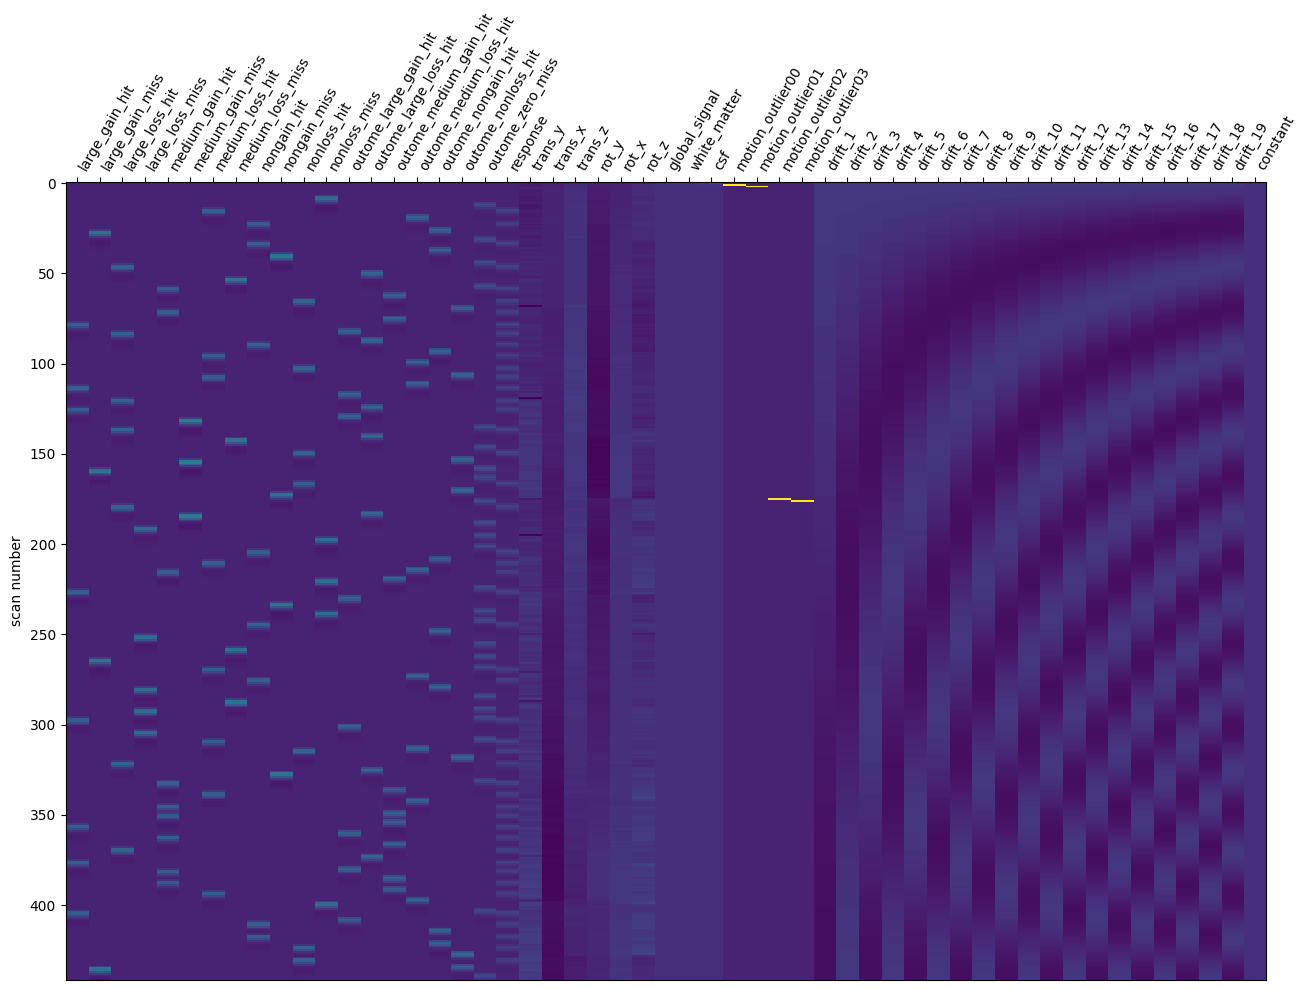

In [672]:
# Fit GLM model to events and confounds files. 
fmri_glm = fmri_glm.fit(sub01_run1_func_file, run1_events, sub01_run1_confounds_df_alt)

plot_design_matrix(fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 3.005


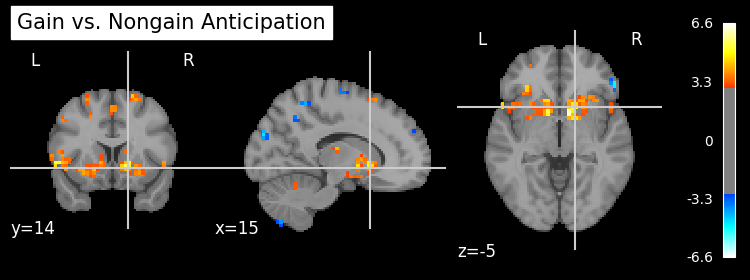

In [673]:
anticipation_gain_contrast = "+1*large_gain_hit+1*large_gain_miss+1*medium_gain_hit+1*medium_gain_miss-2*nongain_hit-2*nongain_miss"

anticipation_gain_z_map = fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map, threshold = threshold_stats_img(anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    anticipation_gain_thresholded_map,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



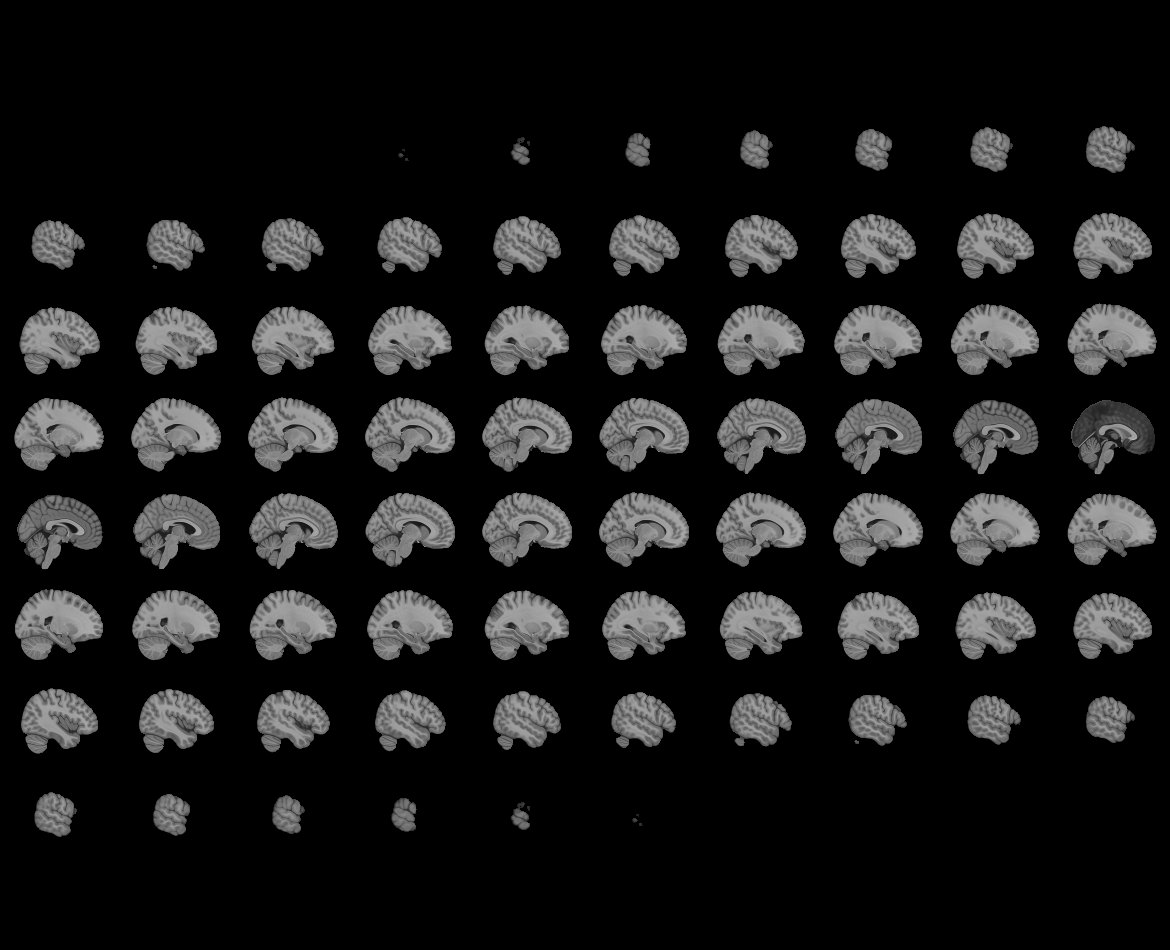
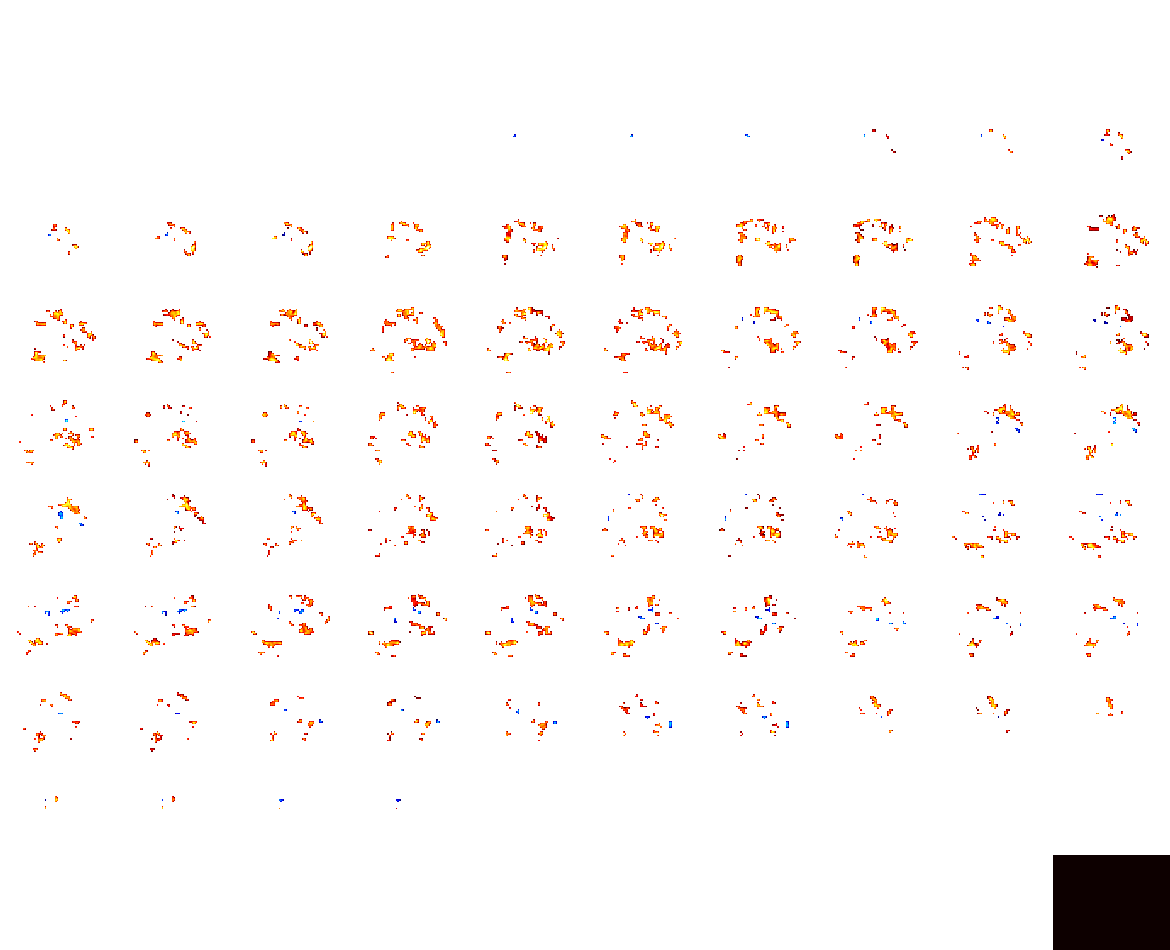

In [474]:
view = view_img(anticipation_gain_thresholded_map, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 002

In [433]:
# Load files for sub 002  
sub02_run1_func_file = "MID_preproc2/sub-02/func/sub-02_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub02_run1_mask_file = "MID_preproc2/sub-02/func/sub-02_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub02_file = 'MID_raw/sub-02/func/sub-02_task-MID_run-1_events.tsv'
sub02_run1_confounds_file = "MID_preproc2/sub-02/func/sub-02_task-MID_run-1_desc-confounds_timeseries.tsv"


In [434]:
# Calculate mean image to use as background image.
sub02_fmri_img = concat_imgs(sub02_run1_func_file)
#sub02_mean_img = mean_img(sub02_fmri_img)

sub02_func_file = nib.load(sub02_run1_func_file)
sub02_func_data = sub02_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub02_func_data.shape))

sub02_n_vols = sub02_func_data.shape[3]
TR = 2

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/1763445346.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub02_func_data = sub02_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [435]:
# Load participants file
sub02_run1_events_raw = pd.read_csv(sub02_file, sep='\t')
sub02_trials_num = sub02_run1_events_raw.shape[0]

print(f"run1_events shape: {sub02_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub02_trials_num}")

sub02_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0007        10      1        -$0      0.25        0.22964    1   
1  26.0038        10      2        -$1      0.25        0.22184    1   
2  40.0022         6      3        +$0      0.25        0.21107    1   
3  50.0012         8      4        +$5      0.25        0.20930    1   
4  62.0010        10      5        +$0      0.25       -1.00000    0   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $5.00    4  
4      $5.00    6

In [522]:
# Create events dataframe for sub001 run 1.
sub02_run1_events = create_events_df(sub02_run1_events_raw, sub02_trials_num, TR)

sub02_run1_events.head()

trial_type     onset duration
0         nonloss_hit  13.00070        2
1            response  13.23034      0.5
2  outome_nonloss_hit  20.00070        2
3     medium_loss_hit  27.00380        2
4            response  27.22564      0.5

In [611]:
# Load confounds file for sub002 run 1. 
sub02_run1_confounds_df = pd.read_csv(sub02_run1_confounds_file, sep='\t')
default_confounds = ['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', "global_signal", "white_matter",
                     'non_steady_state_outlier01', 'non_steady_state_outlier02', 'non_steady_state_outlier03'] # , "csf_wm", "csf"

# Get motion confounds.
sub02_montion_confounds = [i for i in sub02_run1_confounds_df.columns if "motion" in i] 

# Create sub002 confounds df.
sub02_run1_confounds_df = sub02_run1_confounds_df[default_confounds + sub02_montion_confounds] 

# Change NaNs to 0s. 
sub02_run1_confounds_df = sub02_run1_confounds_df.fillna(0) 
sub02_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y     rot_x         rot_z  \
0 -0.013298 -0.031841  0.344652  0.001209  0.000380 -5.293960e-23   
1 -0.005828 -0.055477  0.125777  0.001003  0.000196 -4.698560e-04   
2 -0.006545 -0.068442  0.047799  0.000493  0.000211 -5.554200e-04   
3 -0.010013 -0.034382  0.038182  0.000243  0.000701 -4.854130e-04   
4 -0.015874 -0.029751  0.022009  0.000872  0.000411 -4.377350e-04   

   global_signal  white_matter  non_steady_state_outlier01  \
0    2607.735714   1944.280192                         0.0   
1    2045.539050   1686.781365                         1.0   
2    2022.936892   1681.877644                         0.0   
3    2021.276722   1683.300695                         0.0   
4    2016.156393   1680.648602                         0.0   

   non_steady_state_outlier02  non_steady_state_outlier03  motion_outlier00  \
0                         0.0                         0.0               0.0   
1                         0.0                         0.0               1.0   
2                         1.0                         0.0               0.0   
3                         0.0                         1.0               0.0   
4                         0.0                         0.0               0.0   

   motion_outlier01  motion_outlier02  motion_outlier03  motion_outlier04  
0               0.0               0.0               0.0               0.0  
1               0.0               0.0               0.0               0.0  
2               1.0               0.0               0.0               0.0  
3               0.0               0.0               0.0               0.0  
4               0.0               0.0               0.0               0.0

In [612]:
sub02_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model="cosine",
    high_pass= 0.011,
    slice_time_ref=0.5, 
    mask_img=sub02_run1_mask_file,
    smoothing_fwhm = 4
)

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/glm.py:310: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


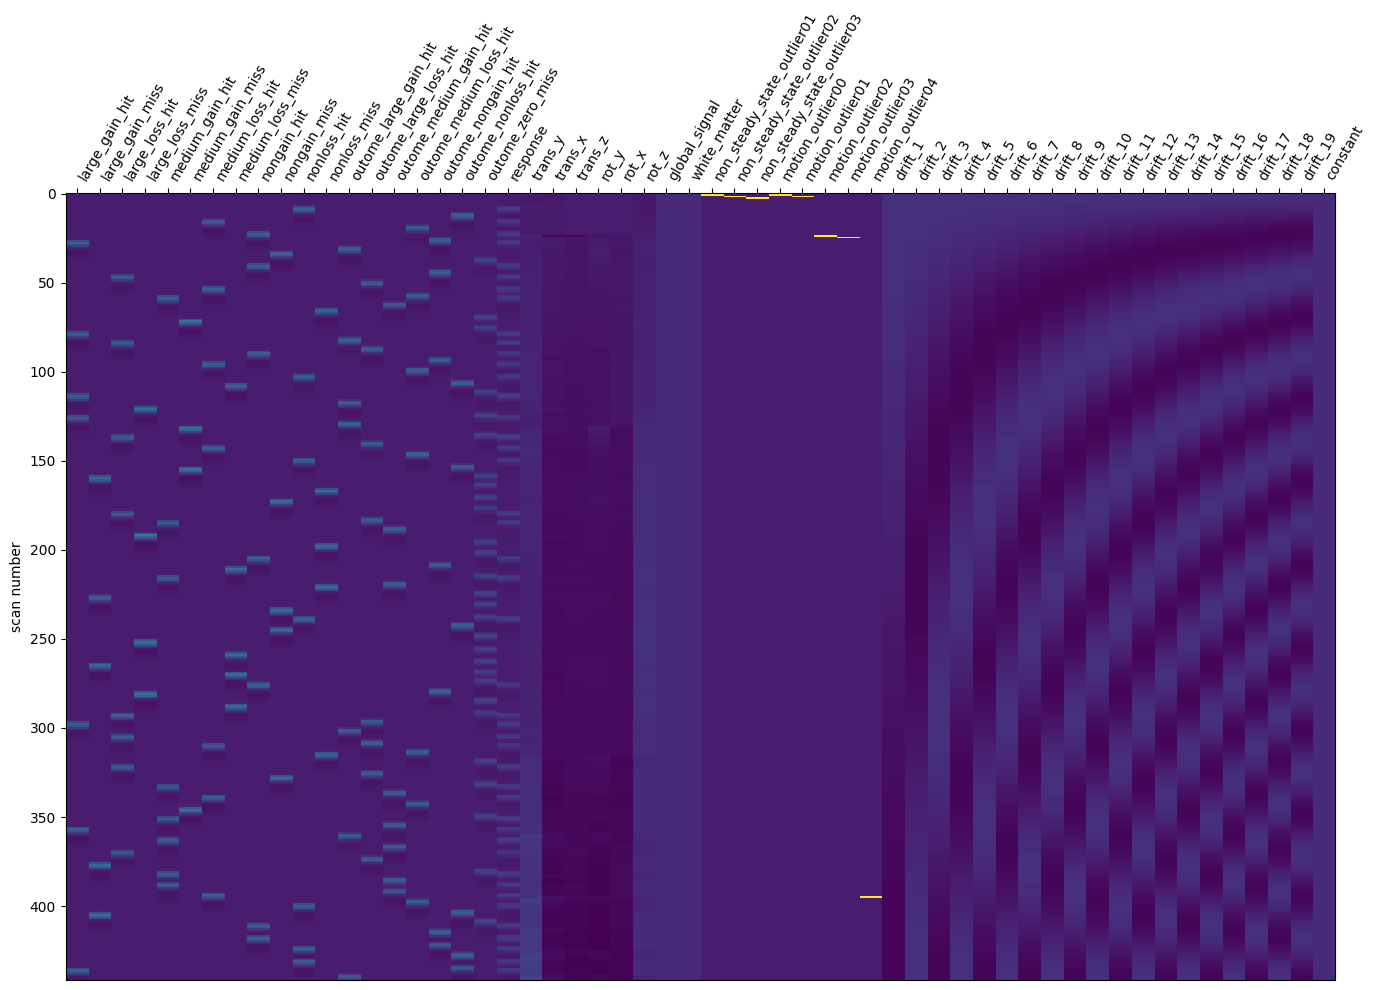

In [613]:
# Fit GLM model to events and confounds files. 
sub02_fmri_glm = sub02_fmri_glm.fit(sub02_run1_func_file, sub02_run1_events, sub02_run1_confounds_df)

plot_design_matrix(sub02_fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 2.650


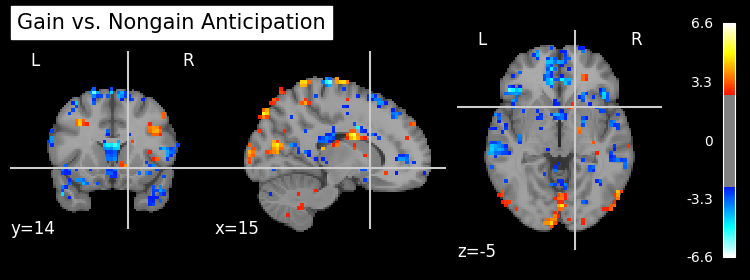

In [614]:
anticipation_gain_contrast = "+1*large_gain_hit+1*large_gain_miss+1*medium_gain_hit+1*medium_gain_miss-2*nongain_hit-2*nongain_miss"

sub02_anticipation_gain_z_map = sub02_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map, threshold = threshold_stats_img(sub02_anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    anticipation_gain_thresholded_map,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



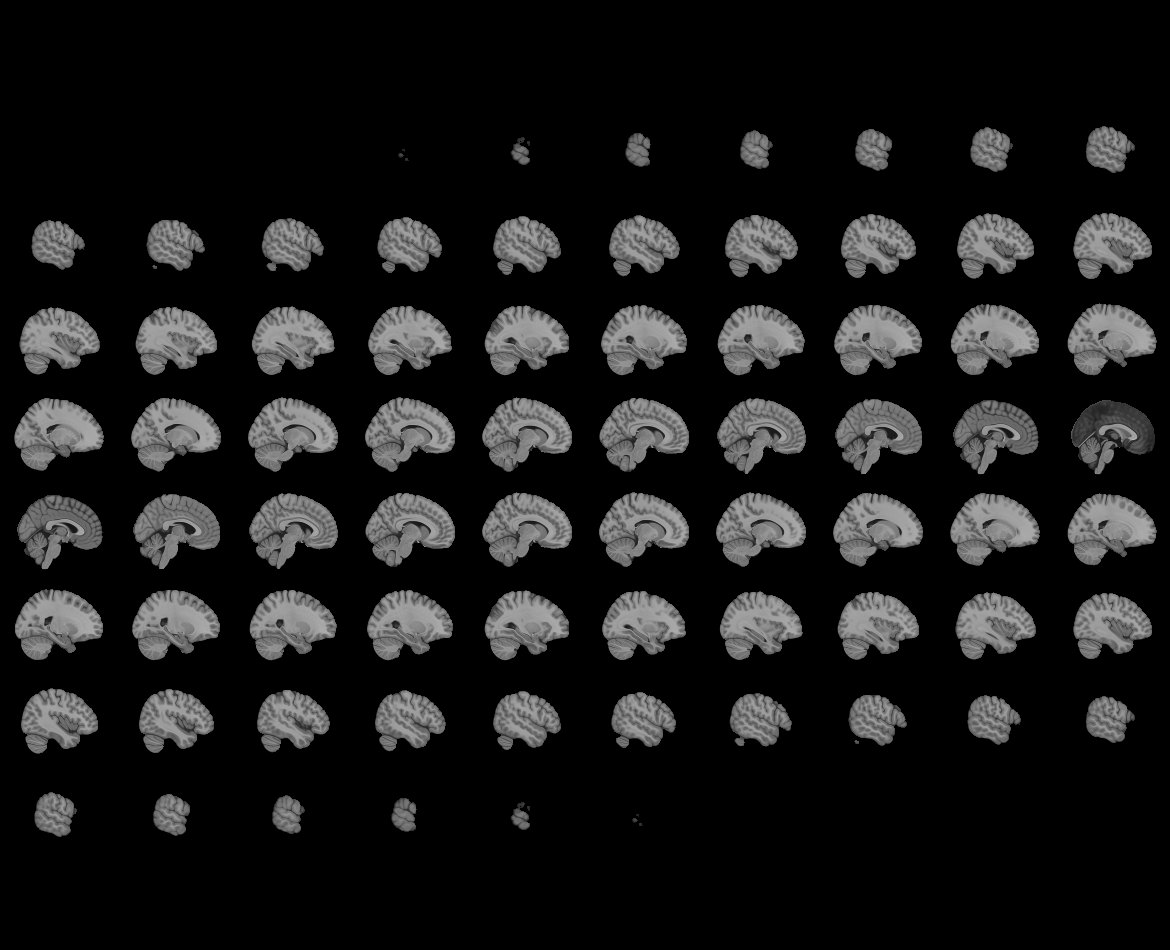
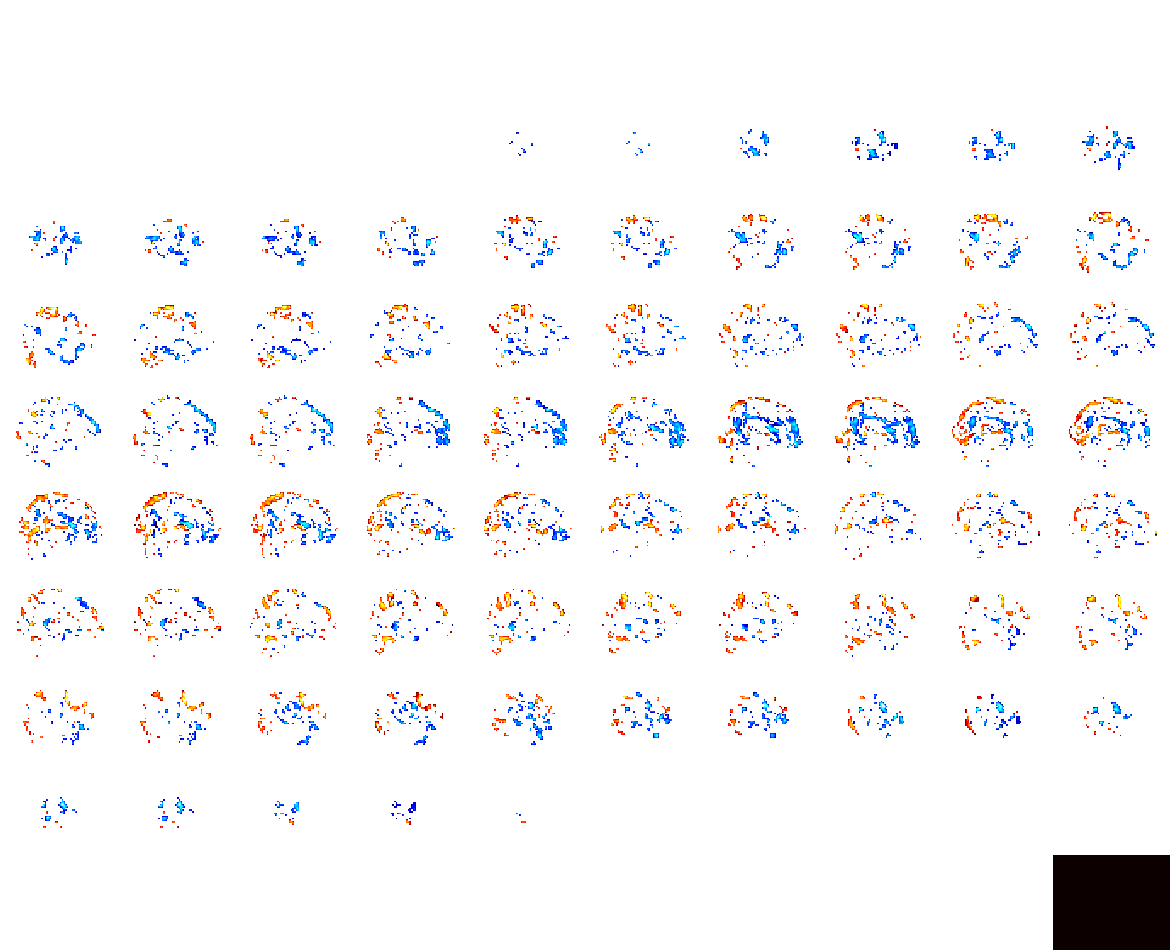

In [615]:
view = view_img(sub02_anticipation_gain_z_map, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 003

In [46]:
# Load files for sub 003  
sub03_run1_func_file = "MID_preproc2/sub-03/func/sub-03_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub03_run1_mask_file = "MID_preproc2/sub-03/func/sub-03_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub03_file = 'MID_raw/sub-03/func/sub-03_task-MID_run-1_events.tsv'
sub03_run1_confounds_file = "MID_preproc2/sub-03/func/sub-03_task-MID_run-1_desc-confounds_timeseries.tsv"

In [47]:
# Calculate mean image to use as background image.
sub03_fmri_img = concat_imgs(sub03_run1_func_file)
#sub02_mean_img = mean_img(sub02_fmri_img)

sub03_func_file = nib.load(sub03_run1_func_file)
sub03_func_data = sub03_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub03_func_data.shape))

sub03_n_vols = sub03_func_data.shape[3]


/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/535436080.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub03_func_data = sub03_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [48]:
# Load participants file
sub03_run1_events_raw = pd.read_csv(sub03_file, sep='\t')
sub03_trials_num = sub03_run1_events_raw.shape[0]

print(f"run1_events shape: {sub03_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub03_trials_num}")

sub03_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0001        10      1        -$0      0.25        0.21721    1   
1  26.0009        10      2        -$1      0.25        0.22994    1   
2  40.0009         6      3        +$0      0.25        0.22072    1   
3  50.0008         8      4        +$5      0.25       -1.00000    0   
4  62.0008        10      5        +$0      0.25        0.24611    1   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $0.00    4  
4      $0.00    6

In [653]:
# Create events dataframe for sub003 run 1.
sub03_run1_events = create_events_df(sub03_run1_events_raw, sub03_trials_num, TR) # works best with TR=1

sub03_run1_events.head()

trial_type     onset duration
0         nonloss_hit  13.00010        2
1            response  13.21731      0.5
2  outome_nonloss_hit  20.00010        2
3     medium_loss_hit  27.00090        2
4            response  27.23084      0.5

In [654]:
# Load confounds file for sub003 run 1. 
sub03_run1_confounds_df = pd.read_csv(sub03_run1_confounds_file, sep='\t')
default_confounds = ['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', "global_signal", "white_matter", "csf", "csf_wm", "tcompcor"]

# Get motion confounds.
sub03_montion_confounds = [i for i in sub03_run1_confounds_df.columns if "motion" in i] 

# Create sub003 confounds df.
sub03_run1_confounds_df = sub03_run1_confounds_df[default_confounds + sub03_montion_confounds] 

#sub03_run1_confounds_df = sub03_run1_confounds_df[["global_signal", 'trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
#                                                'non_steady_state_outlier00', 'non_steady_state_outlier01', "non_steady_state_outlier02", 
#                                                "non_steady_state_outlier03", "non_steady_state_outlier04", "non_steady_state_outlier05", 
#                                                "white_matter", "csf", "csf_wm", "tcompcor"]]


# Change NaNs to 0s. 
sub03_run1_confounds_df = sub03_run1_confounds_df.fillna(0) 
sub03_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y     rot_x     rot_z  global_signal  \
0  0.014439 -0.037970  0.050087 -0.000000 -0.000771  0.000000    2819.622174   
1  0.032959 -0.050849 -0.249524  0.000472 -0.000720 -0.000224    2242.543749   
2  0.038551 -0.050773 -0.382847  0.000224 -0.000031 -0.000421    2192.882256   
3  0.016910 -0.047019 -0.420324  0.000624 -0.000285  0.000006    2182.632413   
4  0.016911 -0.050471 -0.420328  0.000830 -0.000324 -0.000421    2178.171246   

   white_matter          csf       csf_wm     tcompcor  motion_outlier00  \
0   2142.066493  3146.476061  2141.873737  2983.132324               0.0   
1   1892.131650  1883.082388  1888.738000  2170.396315               1.0   
2   1882.131797  1775.511190  1877.810461  2042.399424               0.0   
3   1882.319545  1749.686361  1877.707093  2030.470806               0.0   
4   1882.660608  1742.191122  1878.200435  2022.614069               0.0   

   motion_outlier01  
0               0.0  
1               0.0  
2               1.0  
3               0.0  
4               0.0

In [661]:
sub03_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model="cosine",
    high_pass= 0.011,
    slice_time_ref=0.5, 
    mask_img=sub03_run1_mask_file,
    smoothing_fwhm = 4
)

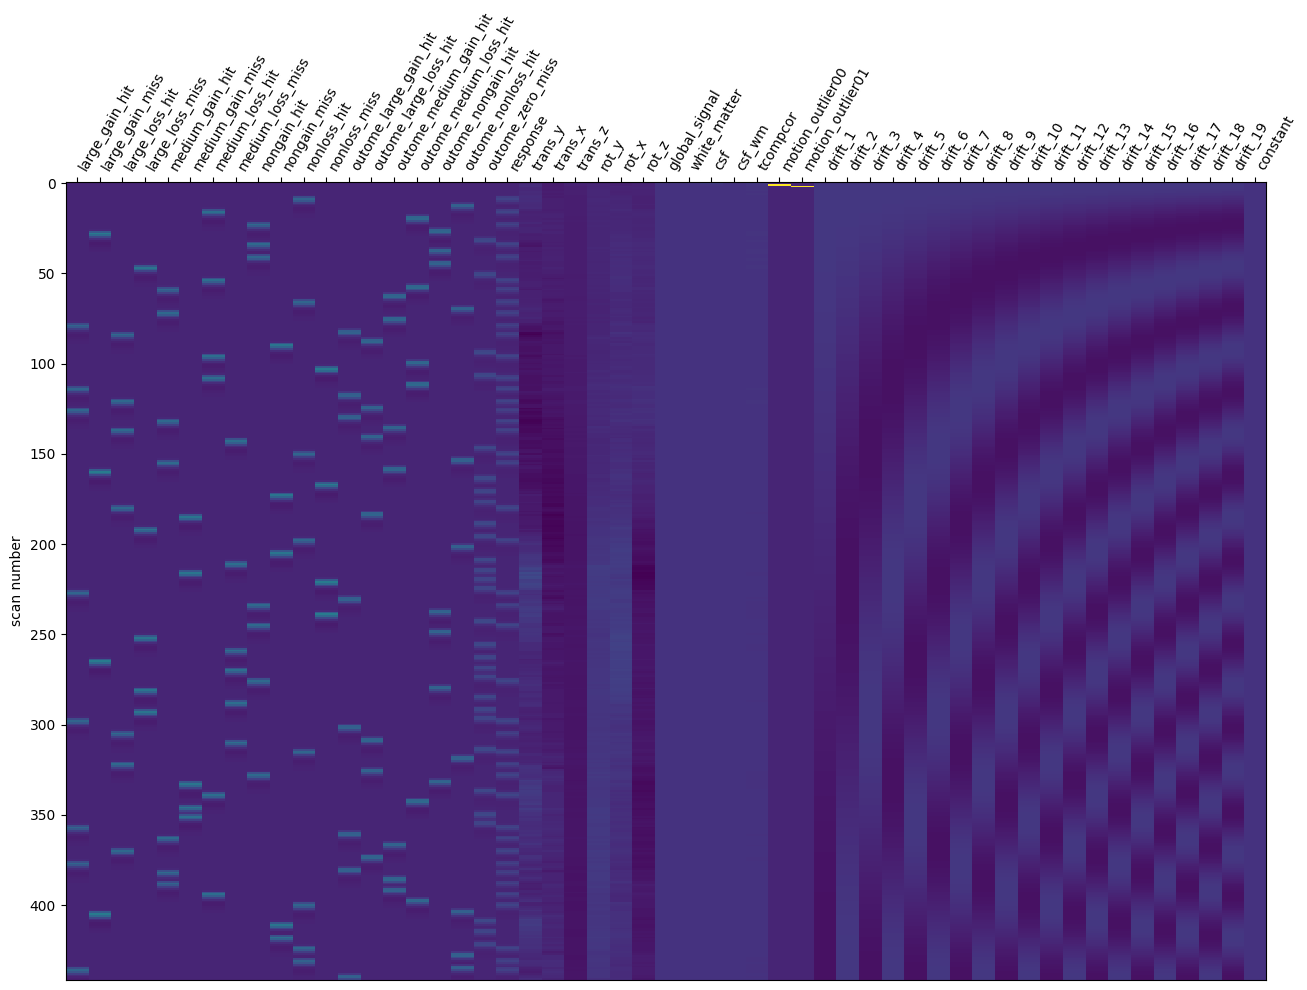

In [662]:
# Fit GLM model to events and confounds files. 
sub03_fmri_glm = sub03_fmri_glm.fit(sub03_run1_func_file, sub03_run1_events, sub03_run1_confounds_df)

plot_design_matrix(sub03_fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 3.011


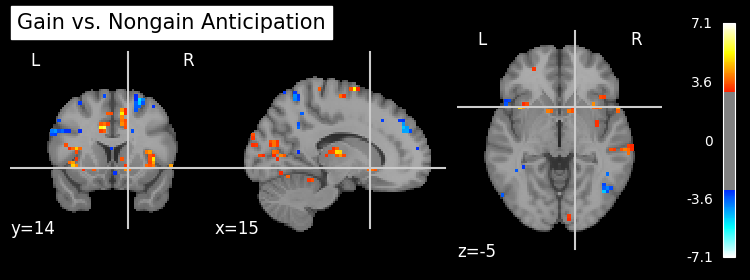

In [663]:
anticipation_gain_contrast = "+1*large_gain_hit+1*large_gain_miss+1*medium_gain_hit+1*medium_gain_miss-2*nongain_hit-2*nongain_miss"

sub03_anticipation_gain_z_map = sub03_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_03, threshold = threshold_stats_img(sub03_anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    anticipation_gain_thresholded_map_03,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



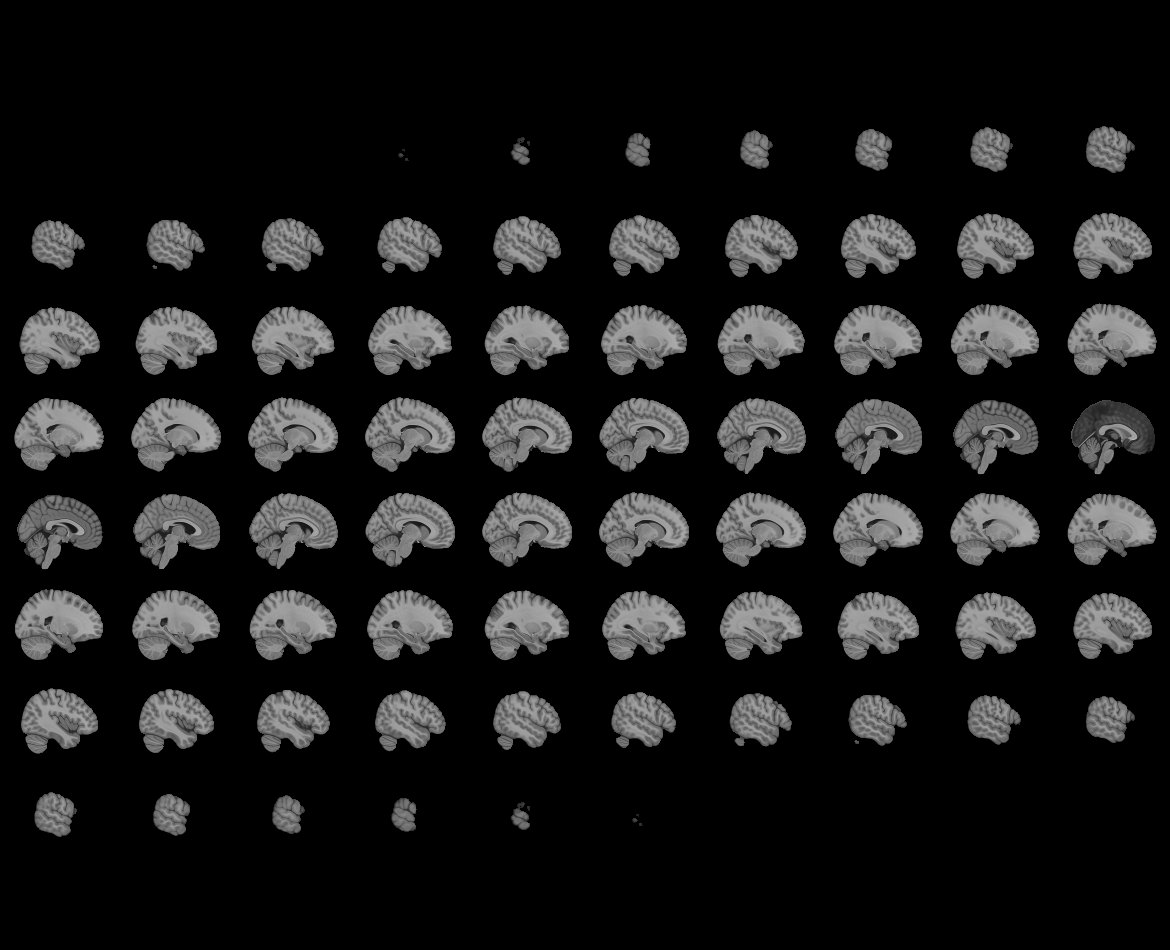
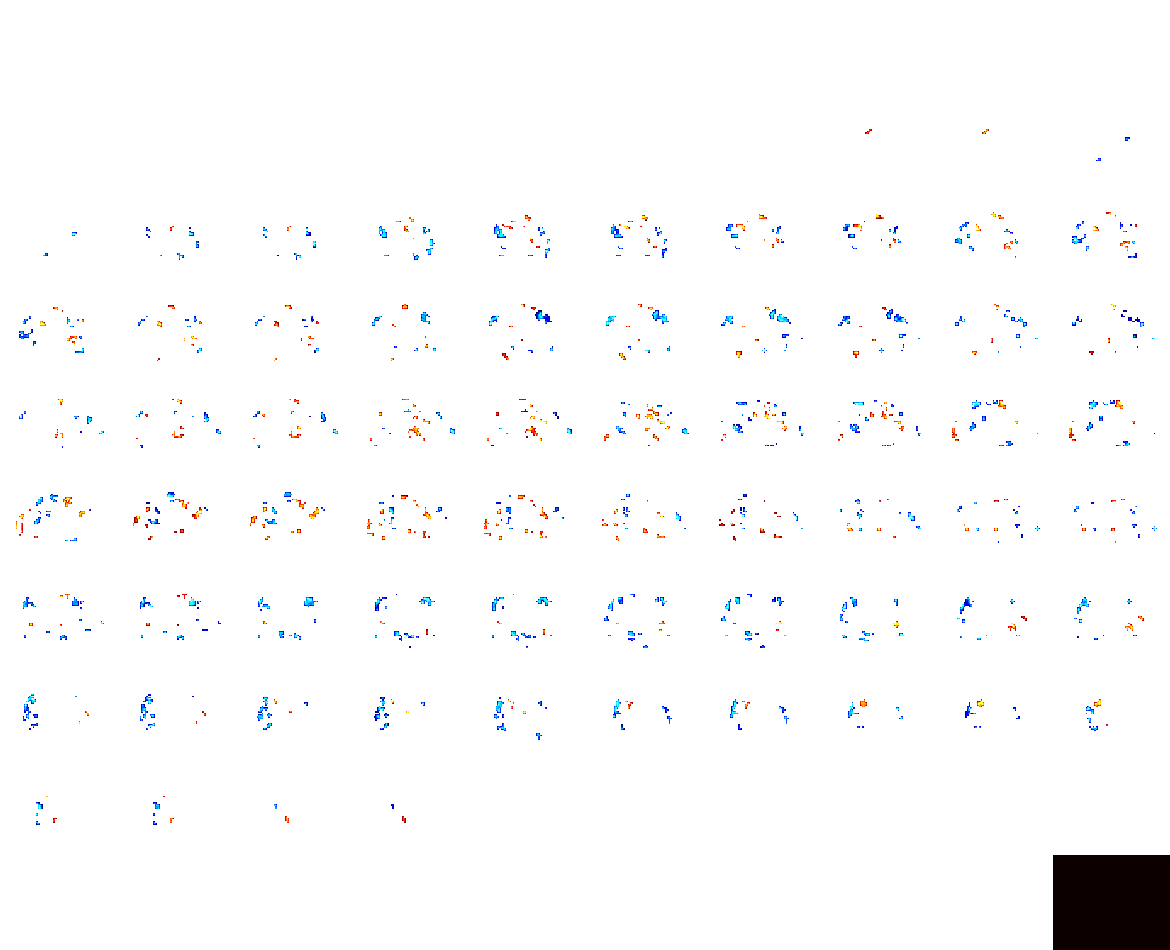

In [30]:
view = view_img(anticipation_gain_thresholded_map_03, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 004

In [181]:
# Load files for sub 004  
sub04_run1_func_file = "MID_preproc2/sub-04/func/sub-04_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub04_run1_mask_file = "MID_preproc2/sub-04/func/sub-04_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub04_file = 'MID_raw/sub-04/func/sub-04_task-MID_run-1_events.tsv'
sub04_run1_confounds_file = "MID_preproc2/sub-04/func/sub-04_task-MID_run-1_desc-confounds_timeseries.tsv"

In [183]:
# Calculate mean image to use as background image.
sub04_fmri_img = concat_imgs(sub04_run1_func_file)
sub04_func_file = nib.load(sub04_run1_func_file)
sub04_func_data = sub04_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub04_func_data.shape))

sub04_n_vols = sub04_func_data.shape[3]


/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/1534425238.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub04_func_data = sub04_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [184]:
# Load participants file
sub04_run1_events_raw = pd.read_csv(sub04_file, sep='\t')
sub04_trials_num = sub04_run1_events_raw.shape[0]

print(f"run1_events shape: {sub04_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub04_trials_num}")

sub04_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0007        10      1        -$0      0.25       -1.00000    0   
1  26.0026        10      2        -$1      0.25        0.23221    1   
2  40.0021         6      3        +$0      0.25        0.23346    1   
3  50.0014         8      4        +$5      0.25        0.23739    1   
4  62.0009        10      5        +$0      0.25       -1.00000    0   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $5.00    4  
4      $5.00    6

In [202]:
# Create events dataframe for sub004 run 1.
sub04_run1_events = create_events_df(sub04_run1_events_raw, sub04_trials_num, TR)

sub04_run1_events.head()

trial_type     onset duration
0            nonloss_miss  13.00070        2
1        outome_zero_miss  20.00070        2
2         medium_loss_hit  27.00260        2
3                response  27.23481      0.5
4  outome_medium_loss_hit  34.00260        2

In [270]:
# Use 'load confounds strategy'
sub04_alternative_confounds, _ = load_confounds_strategy(sub04_run1_func_file, denoise_strategy="scrubbing")
sub04_alternative_confounds

cosine00  cosine01  cosine02  cosine03  cosine04  cosine05  cosine06  \
0   -0.007122 -0.000719  0.002024 -0.004704  0.003378  0.001538 -0.002666   
1   -0.007122 -0.000719  0.002024 -0.004704  0.003378  0.001538 -0.002666   
2   -0.007122 -0.000719  0.002024 -0.004704  0.003378  0.001538 -0.002666   
3   -0.007122 -0.000719  0.002024 -0.004704  0.003378  0.001538 -0.002666   
4   -0.007122 -0.000719  0.002024 -0.004704  0.003378  0.001538 -0.002666   
..        ...       ...       ...       ...       ...       ...       ...   
437 -0.074815  0.066868 -0.065384  0.062455 -0.063462  0.067989 -0.068657   
438 -0.074829  0.066924 -0.065510  0.062680 -0.063813  0.068492 -0.069342   
439 -0.074840  0.066966 -0.065605  0.062848 -0.064076  0.068871 -0.069856   
440 -0.074847  0.066994 -0.065668  0.062961 -0.064251  0.069124 -0.070200   
441 -0.074850  0.067008 -0.065700  0.063017 -0.064339  0.069251 -0.070373   

     cosine07  cosine08  cosine09  ...  trans_y_derivative1_power2  \
0    0.001786 -0.003163  0.001324  ...                   -0.000216   
1    0.001786 -0.003163  0.001324  ...                   -0.000216   
2    0.001786 -0.003163  0.001324  ...                    0.000588   
3    0.001786 -0.003163  0.001324  ...                    0.001231   
4    0.001786 -0.003163  0.001324  ...                   -0.000032   
..        ...       ...       ...  ...                         ...   
437  0.067249 -0.068028  0.065523  ...                    0.000619   
438  0.068141 -0.069154  0.066910  ...                    0.002143   
439  0.068813 -0.070003  0.067957  ...                    0.001951   
440  0.069262 -0.070571  0.068657  ...                   -0.000165   
441  0.069486 -0.070856  0.069009  ...                   -0.000225   

     trans_y_power2   trans_z  trans_z_derivative1  \
0         -0.115096  1.193752            -0.282163   
1         -0.115108  0.903107            -0.282163   
2         -0.114292  0.822973            -0.071652   
3         -0.115016  0.827760             0.013269   
4         -0.115089  0.827576             0.008298   
..              ...       ...                  ...   
437        0.111957 -1.050667             0.029712   
438        0.067917 -0.795137             0.264012   
439        0.110040 -0.922507            -0.118888   
440        0.117664 -1.028387            -0.097398   
441        0.115819 -1.032457             0.004412   

     trans_z_derivative1_power2  trans_z_power2  white_matter  \
0                      0.083490       -1.795828    307.860399   
1                      0.083490       -1.722258     32.788096   
2                      0.005437       -1.672262     27.622122   
3                     -0.000962       -1.675609     28.890018   
4                     -0.000984       -1.675481     28.073849   
..                          ...             ...           ...   
437                   -0.000534        3.157383    -21.218281   
438                    0.064311        2.085232    -22.207378   
439                    0.015239        2.603326    -23.897480   
440                    0.010226        3.058703    -27.640852   
441                   -0.000968        3.076656    -26.652483   

     white_matter_derivative1  white_matter_derivative1_power2  \
0                 -274.894887                     75661.337021   
1                 -274.894887                     75661.337021   
2                   -4.988557                        23.252252   
3                    1.445311                        -1.827466   
4                   -0.638753                        -2.768894   
..                        ...                              ...   
437                  0.392984                        -3.388556   
438                 -0.811681                        -2.456713   
439                 -1.512686                        -0.578580   
440                 -3.565956                        10.577805   
441                  1.165784                        -2.458154   

     white_matte

In [186]:
# Load confounds file for sub004 run 1. 
sub04_run1_confounds_df = pd.read_csv(sub04_run1_confounds_file, sep='\t')
sub04_run1_confounds_df = sub04_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'non_steady_state_outlier00', 'non_steady_state_outlier01', "white_matter", "csf", "csf_wm", "tcompcor"]]

# Change NaNs to 0s. 
sub04_run1_confounds_df = sub04_run1_confounds_df.fillna(0) 
sub04_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y     rot_x     rot_z  \
0  0.003484  0.000183  0.018759  0.000810 -0.000436  0.000000   
1 -0.000004 -0.046823 -0.271886 -0.000533  0.000332 -0.000529   
2 -0.028577 -0.057423 -0.352020 -0.001115  0.000357 -0.000333   
3  0.009631 -0.046689 -0.347233 -0.001035  0.000357 -0.000529   
4 -0.004386 -0.052590 -0.347417 -0.000970  0.000702 -0.000529   

   non_steady_state_outlier00  non_steady_state_outlier01  white_matter  \
0                         1.0                         0.0   2095.583076   
1                         0.0                         1.0   1820.510773   
2                         0.0                         0.0   1815.344800   
3                         0.0                         0.0   1816.612695   
4                         0.0                         0.0   1815.796526   

           csf       csf_wm     tcompcor  
0  2935.842318  2095.583076  2368.491606  
1  1545.291775  1820.510773  1611.104924  
2  1533.073108  1815.344800  1576.316598  
3  1489.004348  1816.612695  1554.287168  
4  1494.375057  1815.796526  1583.836540

In [348]:
sub04_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model= "cosine",
    high_pass= 0.011,
    slice_time_ref=1, 
    mask_img=sub04_run1_mask_file,
    smoothing_fwhm = 4
)

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/glm.py:310: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


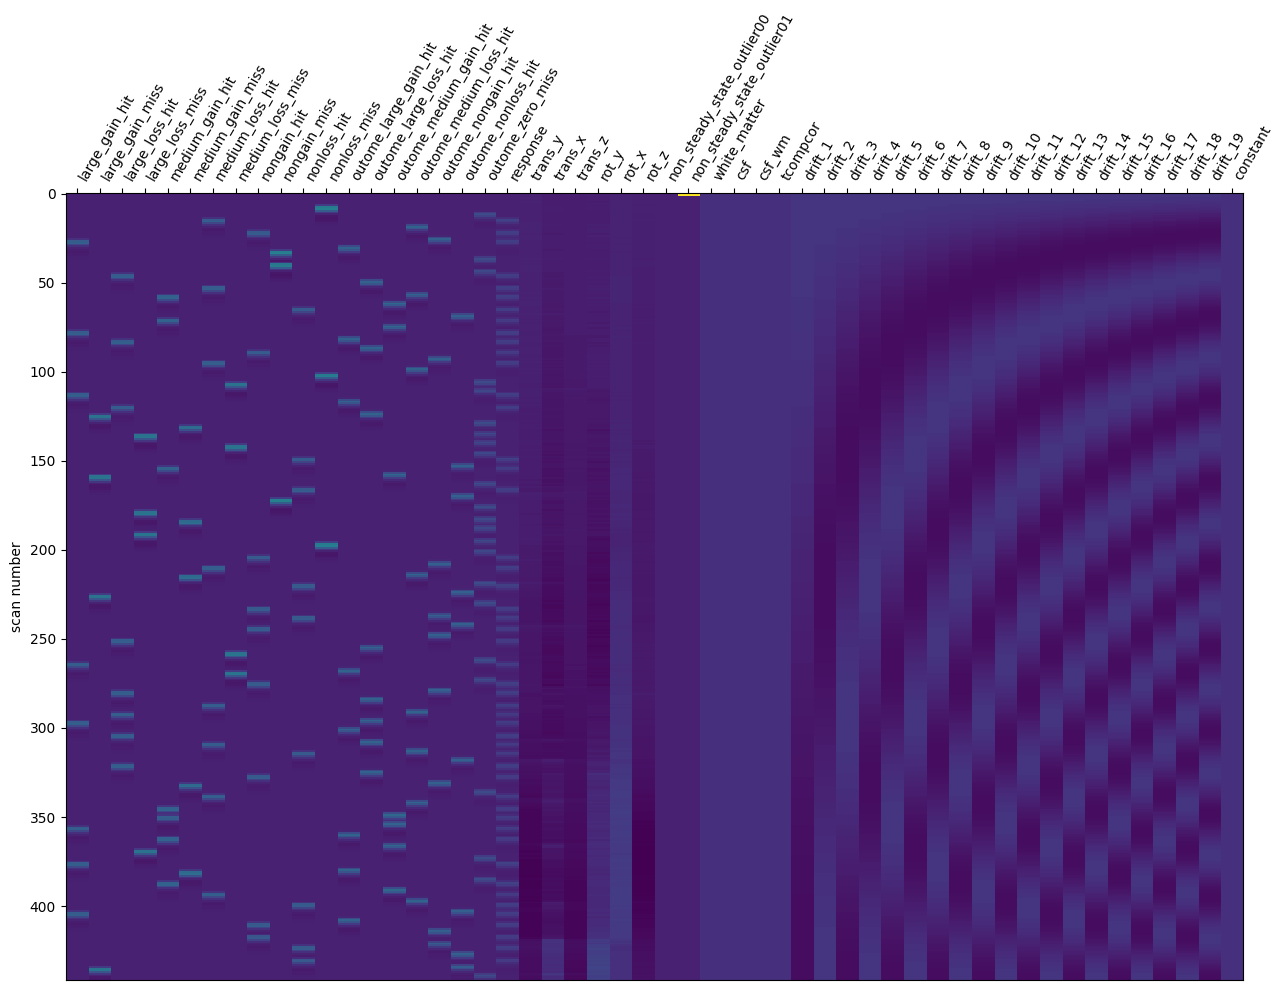

In [349]:
# Fit GLM model to events and confounds files. 
sub04_fmri_glm = sub04_fmri_glm.fit(sub04_run1_func_file, sub04_run1_events, sub04_run1_confounds_df)

plot_design_matrix(sub04_fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 2.807


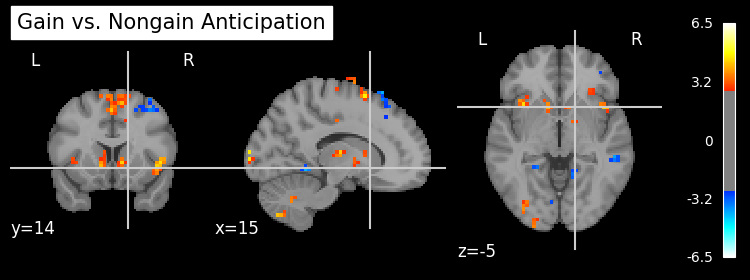

In [350]:
sub04_anticipation_gain_z_map = sub04_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_04, threshold = threshold_stats_img(sub04_anticipation_gain_z_map, alpha=0.005, height_control="fpr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    anticipation_gain_thresholded_map_04,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

FDR p<0.05 threshold: 2.807


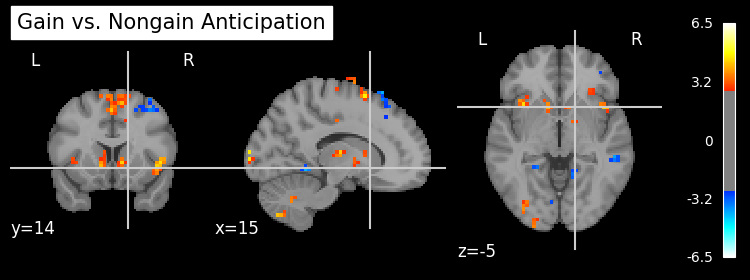

In [224]:
sub04_anticipation_gain_z_map = sub04_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_04, threshold = threshold_stats_img(sub04_anticipation_gain_z_map, alpha=0.005, height_control="fpr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    anticipation_gain_thresholded_map_04,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



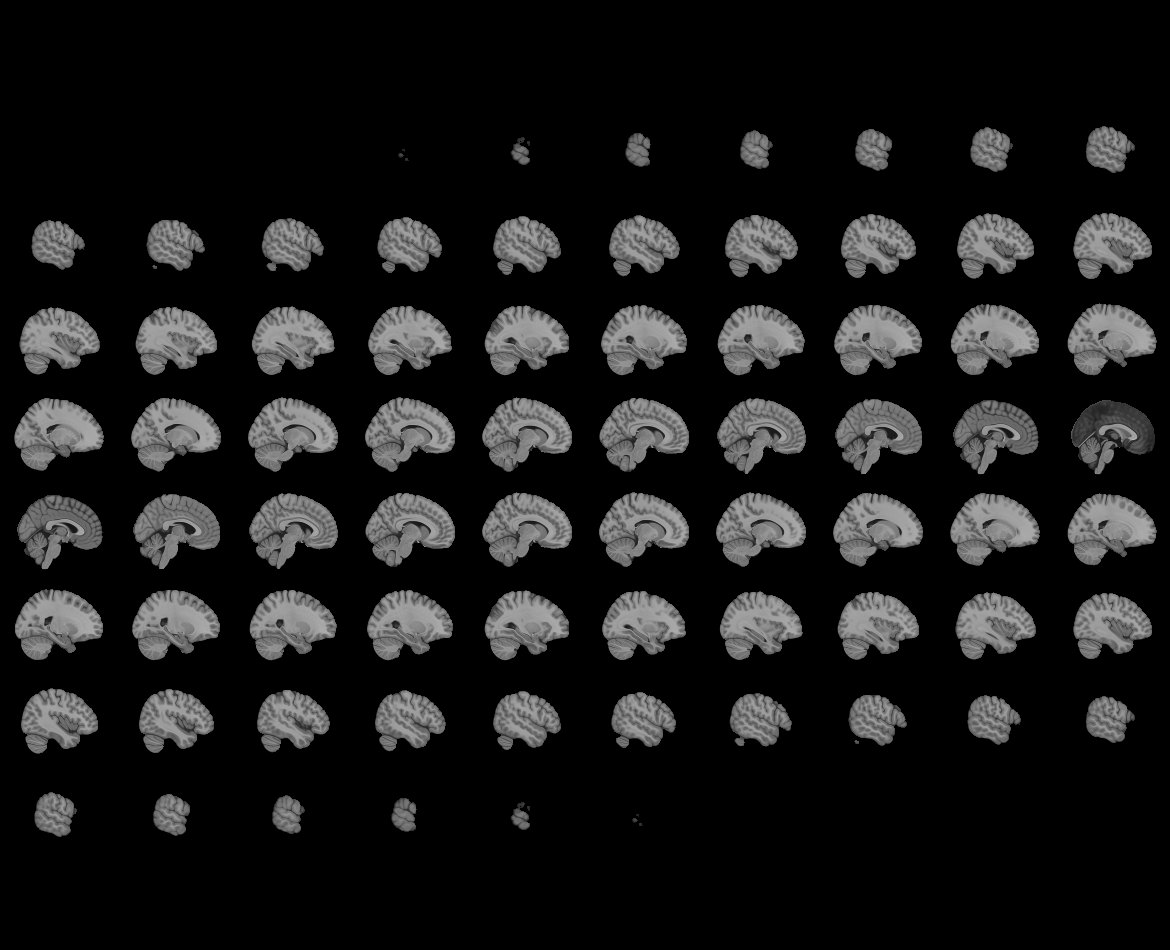
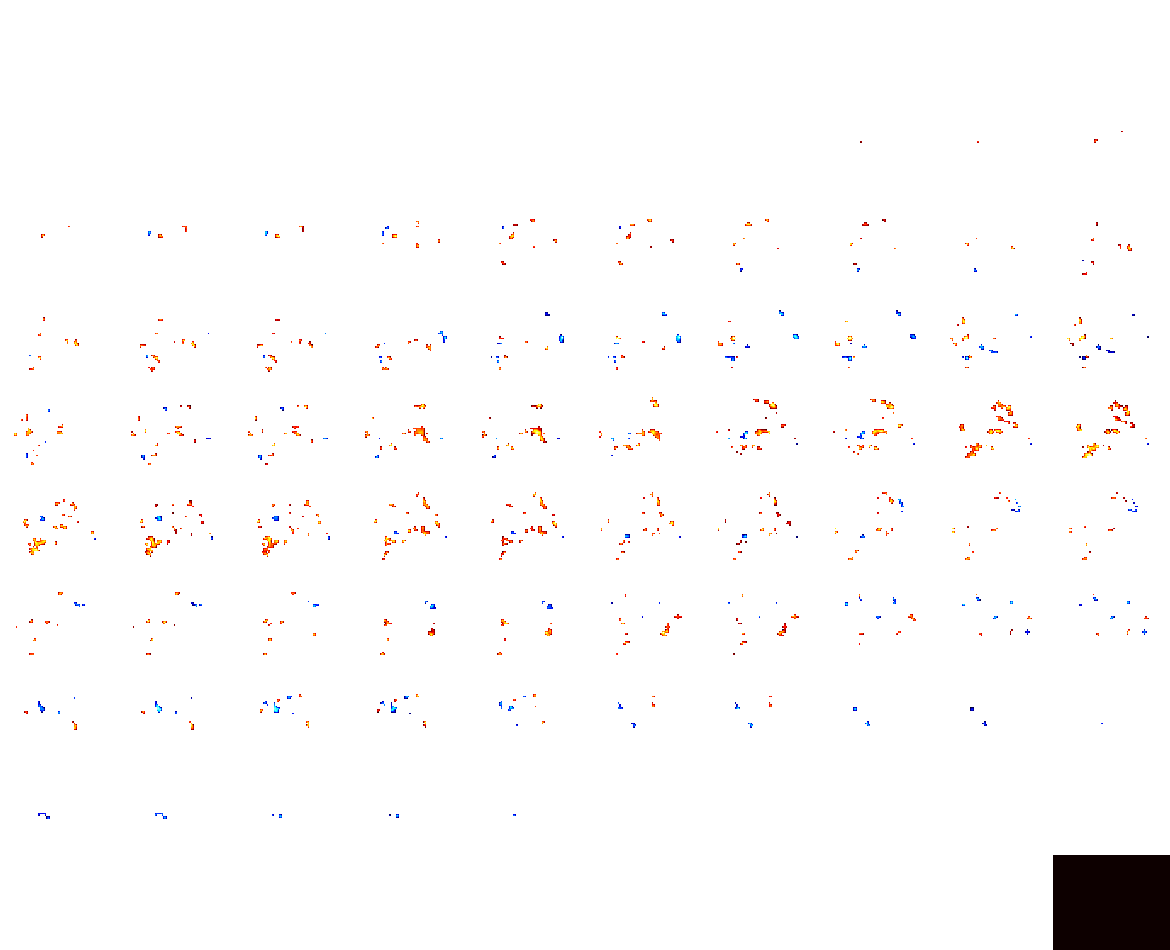

In [71]:
view = view_img(anticipation_gain_thresholded_map_04, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 005

In [283]:
# Load files for sub 005  
sub05_run1_func_file = "MID_preproc2/sub-05/func/sub-05_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub05_run1_mask_file = "MID_preproc2/sub-05/func/sub-05_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub05_file = 'MID_raw/sub-05/func/sub-05_task-MID_run-1_events.tsv'
sub05_run1_confounds_file = "MID_preproc2/sub-05/func/sub-05_task-MID_run-1_desc-confounds_timeseries.tsv"

In [284]:
# Calculate mean image to use as background image.
sub05_fmri_img = concat_imgs(sub05_run1_func_file)
sub05_func_file = nib.load(sub05_run1_func_file)
sub05_func_data = sub05_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub05_func_data.shape))

sub05_n_vols = sub05_func_data.shape[3]

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/2360810479.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub05_func_data = sub05_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [285]:
# Load participants file
sub05_run1_events_raw = pd.read_csv(sub05_file, sep='\t')
sub05_trials_num = sub05_run1_events_raw.shape[0]

print(f"run1_events shape: {sub05_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub05_trials_num}")

sub05_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0001        10      1        -$0      0.25        0.22104    1   
1  26.0008        10      2        -$1      0.25        0.22260    1   
2  40.0006         6      3        +$0      0.25        0.23812    1   
3  50.0008         8      4        +$5      0.25        0.23819    1   
4  62.0007        10      5        +$0      0.25        0.21699    1   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $5.00    4  
4      $5.00    6

In [322]:
# Create events dataframe for sub005 run 1.
sub05_run1_events = create_events_df(sub05_run1_events_raw, sub05_trials_num, TR)

sub05_run1_events.head()

trial_type     onset duration
0         nonloss_hit  13.00010        2
1            response  13.22114      0.5
2  outome_nonloss_hit  20.00010        2
3     medium_loss_hit  27.00080        2
4            response  27.22340      0.5

In [323]:
# Load confounds file for sub005 run 1. 
sub05_run1_confounds_df = pd.read_csv(sub05_run1_confounds_file, sep='\t')
sub05_run1_confounds_df = sub05_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'non_steady_state_outlier00', 'non_steady_state_outlier01', "white_matter", "csf", "csf_wm", "tcompcor"]]

# Change NaNs to 0s. 
sub05_run1_confounds_df = sub05_run1_confounds_df.fillna(0) 
sub05_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y     rot_x     rot_z  \
0  0.000003 -0.028985 -0.000063 -0.000272 -0.000415  0.000000   
1 -0.034104 -0.111369 -0.365269 -0.000705  0.000089 -0.000904   
2 -0.013195 -0.114228 -0.511699 -0.000355  0.000120 -0.000229   
3 -0.013401 -0.113873 -0.548798 -0.002295  0.001293 -0.000466   
4 -0.003453 -0.111062 -0.569323 -0.001399  0.000921 -0.000616   

   non_steady_state_outlier00  non_steady_state_outlier01  white_matter  \
0                         1.0                         0.0   1997.700823   
1                         0.0                         1.0   1735.736057   
2                         0.0                         0.0   1725.746821   
3                         0.0                         0.0   1722.321962   
4                         0.0                         0.0   1720.873616   

           csf       csf_wm     tcompcor  
0  3468.895872  1997.614109  2445.185355  
1  1940.875011  1734.900721  1665.810788  
2  1822.411921  1724.689601  1586.505107  
3  1787.260642  1721.277762  1557.369887  
4  1788.964097  1719.958549  1554.728663

In [351]:
sub05_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model= "cosine",
    high_pass= 0.011,
    slice_time_ref=1, 
    mask_img=sub05_run1_mask_file,
    smoothing_fwhm = 4
)

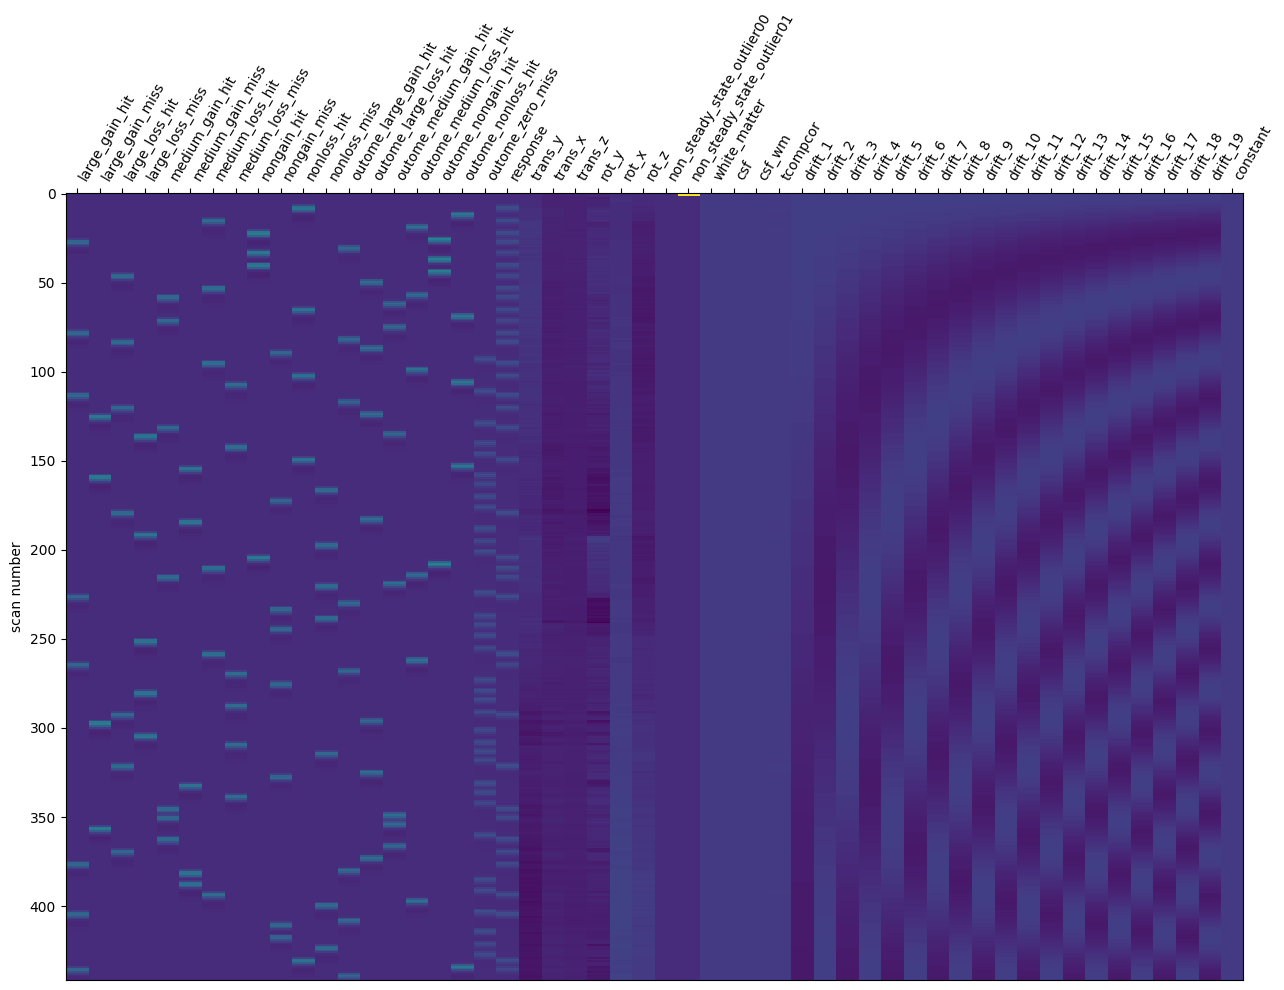

In [352]:
# Fit GLM model to events and confounds files. 
sub05_fmri_glm = sub05_fmri_glm.fit(sub05_run1_func_file, sub05_run1_events, sub05_run1_confounds_df)

plot_design_matrix(sub05_fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 2.705


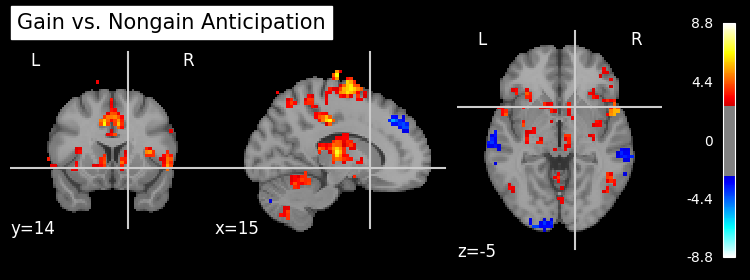

In [353]:
sub05_anticipation_gain_z_map = sub05_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_05, threshold = threshold_stats_img(sub05_anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    anticipation_gain_thresholded_map_05,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



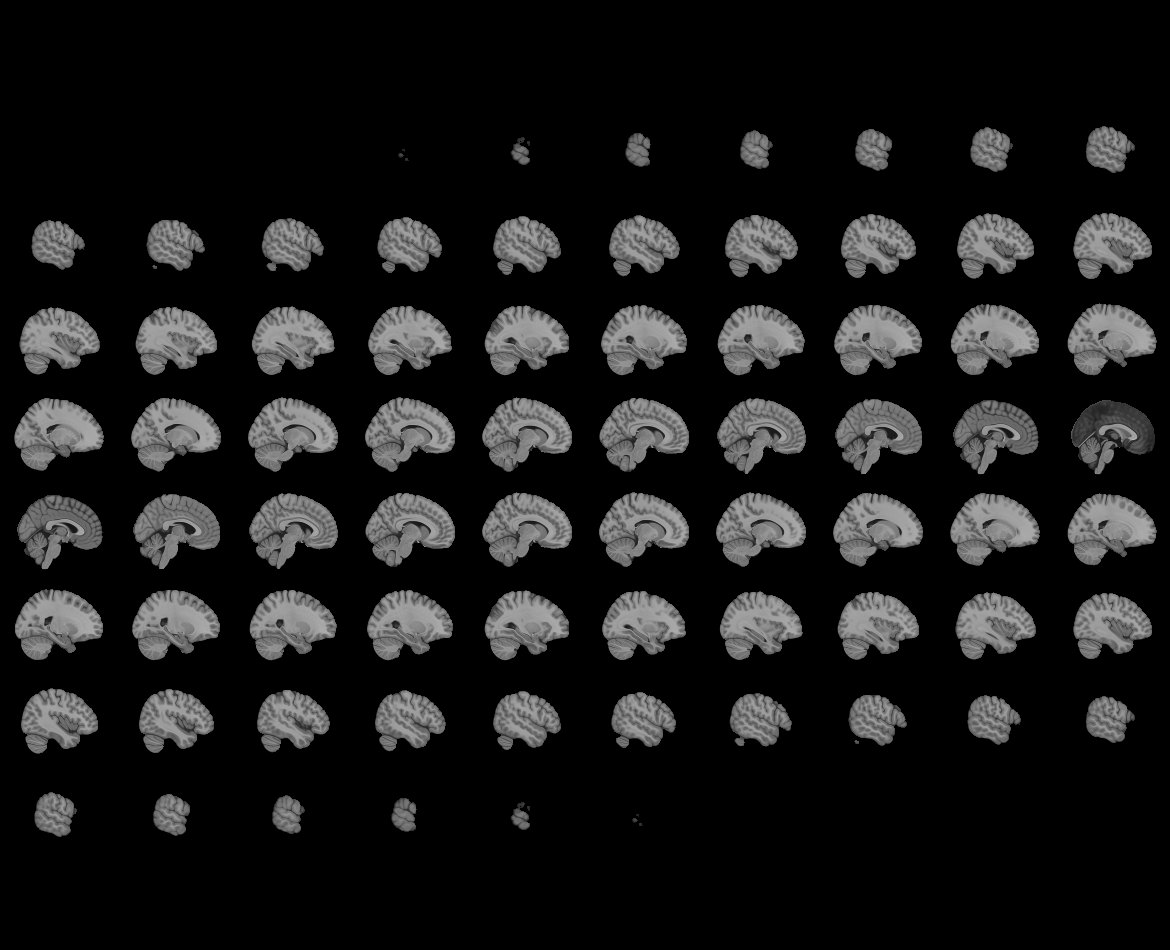
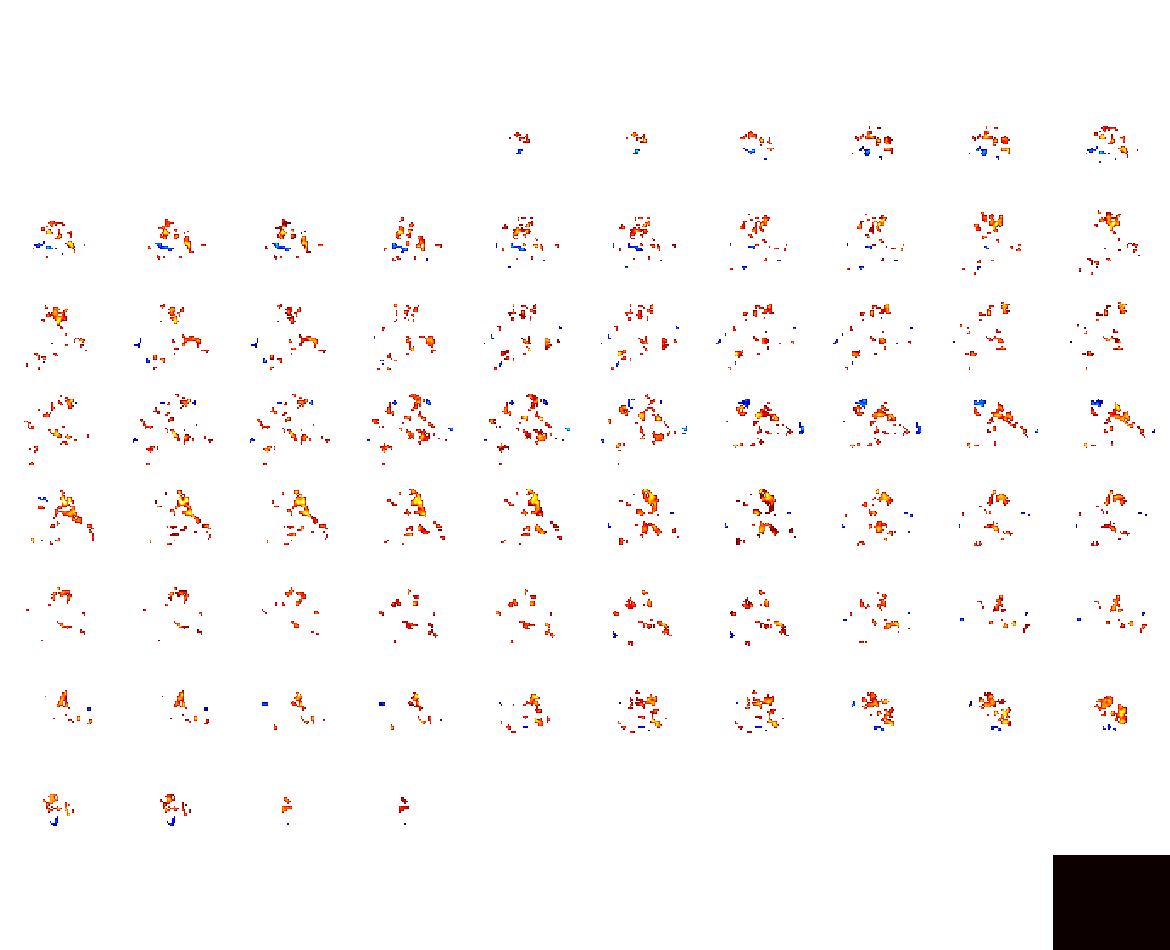

In [346]:
view = view_img(anticipation_gain_thresholded_map_05, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 006

In [327]:
# Load files for sub 006  
sub06_run1_func_file = "MID_preproc2/sub-06/func/sub-06_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub06_run1_mask_file = "MID_preproc2/sub-06/func/sub-06_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub06_file = 'MID_raw/sub-06/func/sub-06_task-MID_run-1_events.tsv'
sub06_run1_confounds_file = "MID_preproc2/sub-06/func/sub-06_task-MID_run-1_desc-confounds_timeseries.tsv"

In [328]:
# Calculate mean image to use as background image.
sub06_fmri_img = concat_imgs(sub06_run1_func_file)
sub06_func_file = nib.load(sub06_run1_func_file)
sub06_func_data = sub06_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub06_func_data.shape))

sub06_n_vols = sub06_func_data.shape[3]

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/2851761556.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub06_func_data = sub06_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [329]:
# Load participants file
sub06_run1_events_raw = pd.read_csv(sub06_file, sep='\t')
sub06_trials_num = sub06_run1_events_raw.shape[0]

print(f"run1_events shape: {sub06_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub06_trials_num}")

sub06_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0001        10      1        -$0      0.25        0.18630    1   
1  26.0009        10      2        -$1      0.25        0.19711    1   
2  40.0009         6      3        +$0      0.25        0.19441    1   
3  50.0008         8      4        +$5      0.25        0.19476    1   
4  62.0008        10      5        +$0      0.25        0.22764    1   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $5.00    4  
4      $5.00    6

In [330]:
# Create events dataframe for sub006 run 1.
sub06_run1_events = create_events_df(sub06_run1_events_raw, sub06_trials_num, TR)

sub06_run1_events.head()

trial_type     onset duration
0         nonloss_hit  13.00010        2
1            response  13.18640      0.5
2  outome_nonloss_hit  20.00010        2
3     medium_loss_hit  27.00090        2
4            response  27.19801      0.5

In [331]:
# Load confounds file for sub006 run 1. 
sub06_run1_confounds_df = pd.read_csv(sub06_run1_confounds_file, sep='\t')
sub06_run1_confounds_df = sub06_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'non_steady_state_outlier00', 'non_steady_state_outlier01', "white_matter", "csf", "csf_wm", "tcompcor"]]

# Change NaNs to 0s. 
sub06_run1_confounds_df = sub06_run1_confounds_df.fillna(0) 
sub06_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y         rot_x     rot_z  \
0  0.009098  0.007062  0.000672  0.000951  4.475960e-04  0.000137   
1  0.038307 -0.061631 -0.299985 -0.000413  0.000000e+00 -0.000321   
2  0.047374 -0.051046 -0.406926 -0.000567 -2.646980e-23 -0.000321   
3  0.038397 -0.061778 -0.458882 -0.000964 -1.574330e-04 -0.000321   
4  0.038267 -0.049816 -0.477175 -0.000964  7.423830e-05 -0.000182   

   non_steady_state_outlier00  non_steady_state_outlier01  white_matter  \
0                         1.0                         0.0   1918.195767   
1                         0.0                         1.0   1676.200269   
2                         0.0                         0.0   1664.415715   
3                         0.0                         0.0   1664.791832   
4                         0.0                         0.0   1664.624819   

           csf       csf_wm     tcompcor  
0  3062.856636  1952.819183  2632.397655  
1  1558.699479  1654.435705  1808.021267  
2  1479.566615  1641.149865  1732.603409  
3  1449.928183  1640.211900  1693.087143  
4  1443.343174  1639.999884  1686.510097

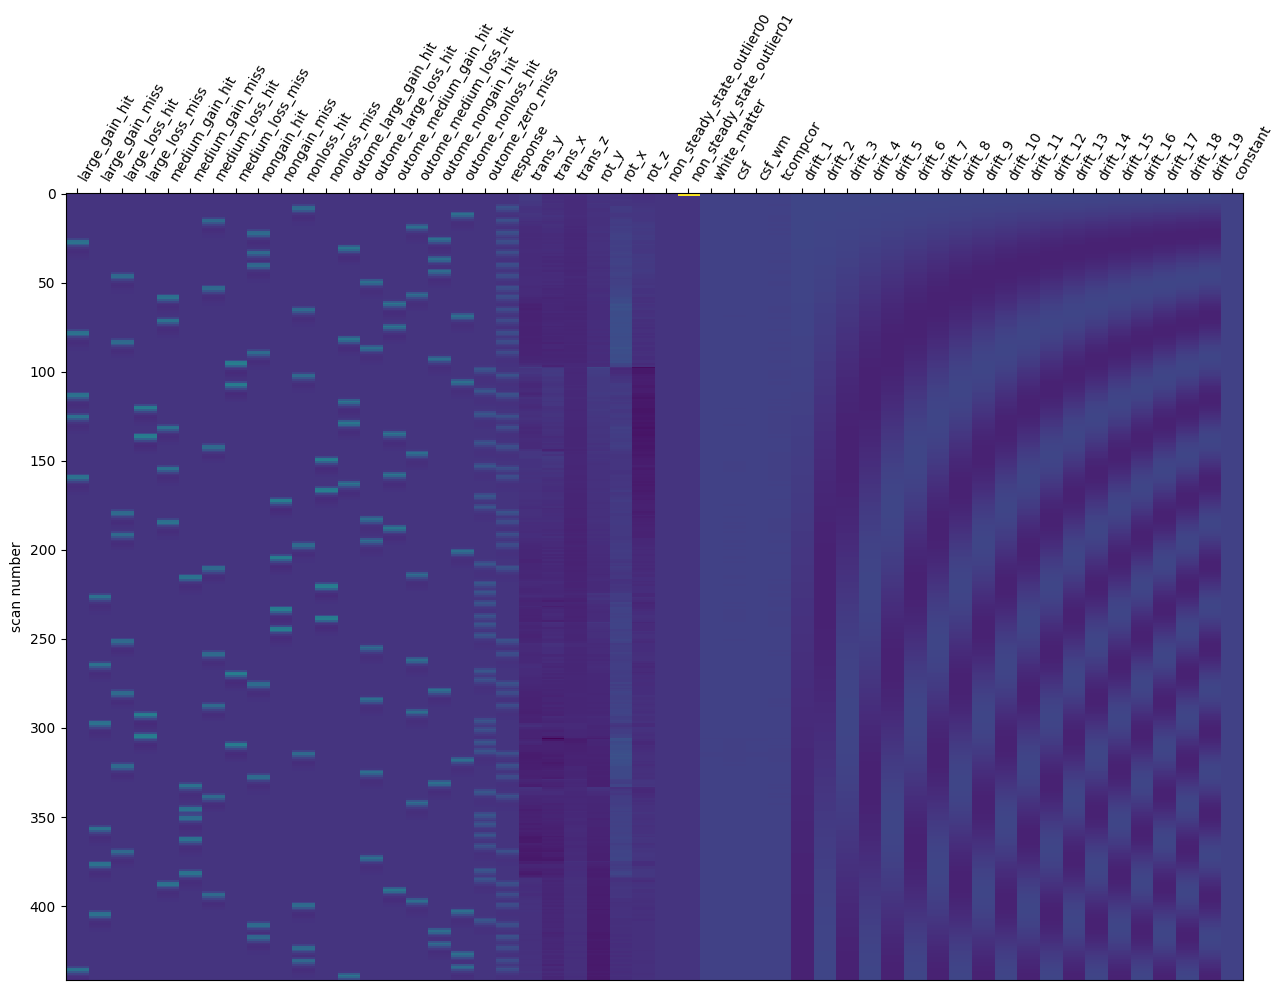

In [354]:
sub06_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model= "cosine",
    high_pass= 0.011,
    slice_time_ref=1, 
    mask_img=sub06_run1_mask_file,
    smoothing_fwhm = 4)

# Fit GLM model to events and confounds files. 
sub06_fmri_glm = sub06_fmri_glm.fit(sub06_run1_func_file, sub06_run1_events, sub06_run1_confounds_df)

plot_design_matrix(sub06_fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 2.744


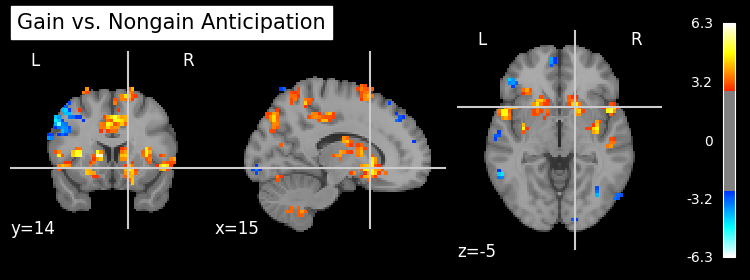

In [355]:
sub06_anticipation_gain_z_map = sub06_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_06, threshold = threshold_stats_img(sub06_anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    anticipation_gain_thresholded_map_06,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

In [ ]:
view = view_img(anticipation_gain_thresholded_map_06, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 007

In [336]:
# Load files for sub 007  
sub07_run1_func_file = "MID_preproc2/sub-07/func/sub-07_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub07_run1_mask_file = "MID_preproc2/sub-07/func/sub-07_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub07_file = 'MID_raw/sub-07/func/sub-07_task-MID_run-1_events.tsv'
sub07_run1_confounds_file = "MID_preproc2/sub-07/func/sub-07_task-MID_run-1_desc-confounds_timeseries.tsv"

# Calculate mean image to use as background image.
sub07_fmri_img = concat_imgs(sub07_run1_func_file)
sub07_func_file = nib.load(sub07_run1_func_file)
sub07_func_data = sub07_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub07_func_data.shape))

sub07_n_vols = sub07_func_data.shape[3]

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/4168726508.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub07_func_data = sub07_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [337]:
# Load participants file
sub07_run1_events_raw = pd.read_csv(sub07_file, sep='\t')
sub07_trials_num = sub07_run1_events_raw.shape[0]

print(f"run1_events shape: {sub07_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub07_trials_num}")

sub07_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0007        10      1        -$0      0.25        0.22565    1   
1  26.0032        10      2        -$1      0.25        0.20728    1   
2  40.0021         6      3        +$0      0.25       -1.00000    0   
3  50.0016         8      4        +$5      0.25        0.22507    1   
4  62.0009        10      5        +$0      0.25        0.22047    1   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $5.00    4  
4      $5.00    6

In [338]:
# Create events dataframe for sub007 run 1.
sub07_run1_events = create_events_df(sub07_run1_events_raw, sub07_trials_num, TR)

sub07_run1_events.head()

trial_type     onset duration
0         nonloss_hit  13.00070        2
1            response  13.22635      0.5
2  outome_nonloss_hit  20.00070        2
3     medium_loss_hit  27.00320        2
4            response  27.21048      0.5

In [339]:
# Load confounds file for sub007 run 1. 
sub07_run1_confounds_df = pd.read_csv(sub07_run1_confounds_file, sep='\t')
sub07_run1_confounds_df = sub07_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'non_steady_state_outlier00', 'non_steady_state_outlier01', "white_matter", "csf", "csf_wm", "tcompcor"]]

# Change NaNs to 0s. 
sub07_run1_confounds_df = sub07_run1_confounds_df.fillna(0) 
sub07_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y     rot_x     rot_z  \
0  0.000169 -0.000059  0.041703 -0.000061 -0.000667  0.000573   
1  0.064231 -0.013295 -0.237818 -0.000676 -0.000025 -0.001291   
2  0.063750 -0.028313 -0.408841 -0.001232  0.000727 -0.001276   
3  0.074174 -0.066245 -0.520362 -0.001633  0.001298 -0.000958   
4  0.088090 -0.049147 -0.486535 -0.001748  0.000467 -0.001199   

   non_steady_state_outlier00  non_steady_state_outlier01  white_matter  \
0                         1.0                         0.0   1885.484485   
1                         0.0                         1.0   1633.303957   
2                         0.0                         0.0   1625.918937   
3                         0.0                         0.0   1621.131660   
4                         0.0                         0.0   1620.218320   

           csf       csf_wm     tcompcor  
0  3103.782983  1884.322644  2092.942770  
1  1738.451664  1632.169620  1528.185852  
2  1651.876455  1624.742031  1430.479005  
3  1604.366436  1620.005087  1406.312601  
4  1587.498484  1619.073942  1404.565766

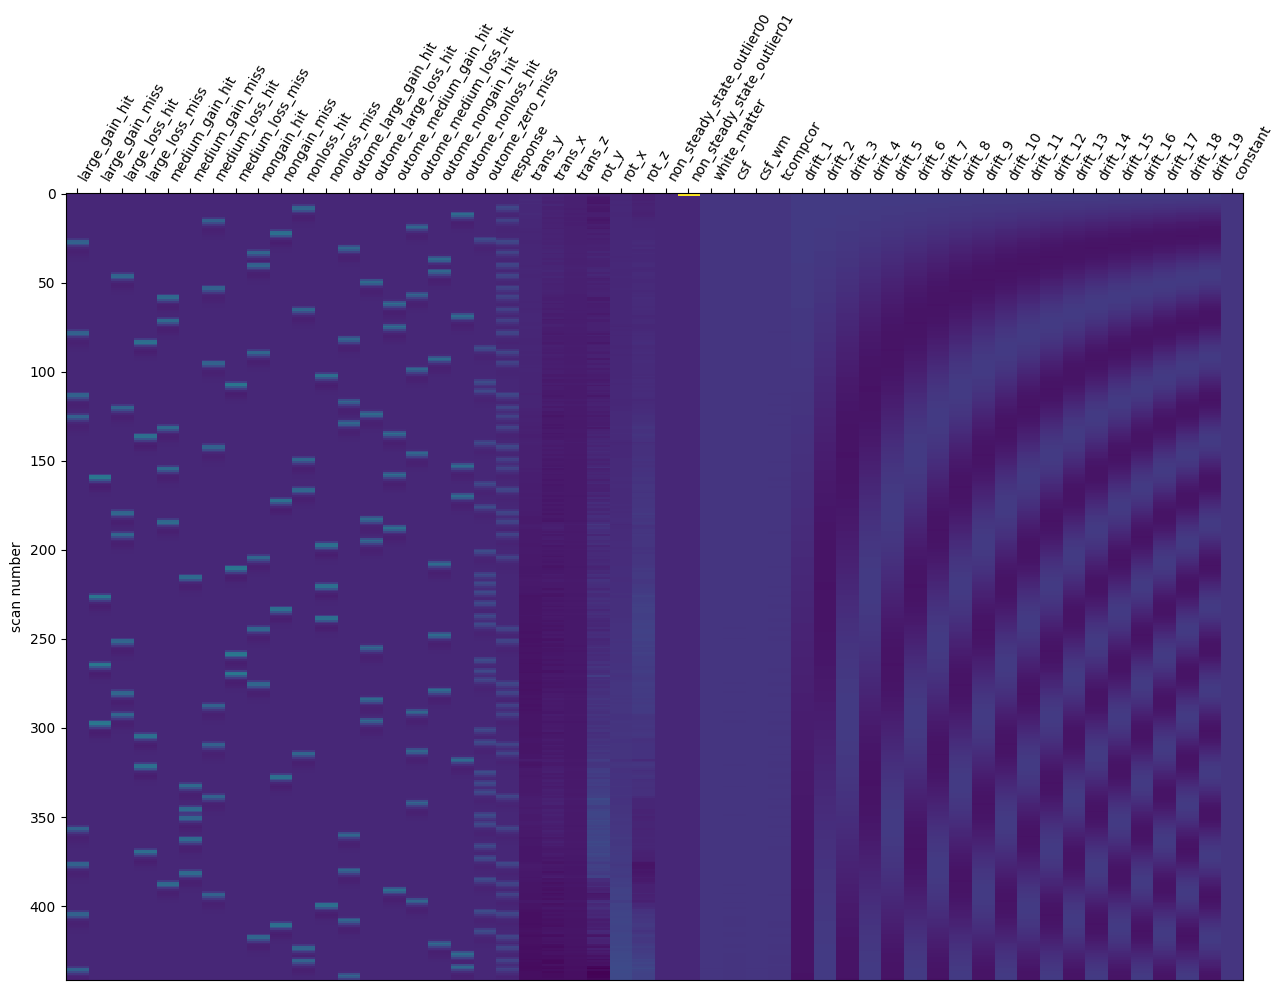

In [370]:
sub07_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model= "cosine",
    high_pass= 0.011,
    slice_time_ref=1, 
    mask_img=sub07_run1_mask_file,
    smoothing_fwhm = 4)

# Fit GLM model to events and confounds files. 
sub07_fmri_glm = sub07_fmri_glm.fit(sub07_run1_func_file, sub07_run1_events, sub07_run1_confounds_df)

plot_design_matrix(sub07_fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 3.984


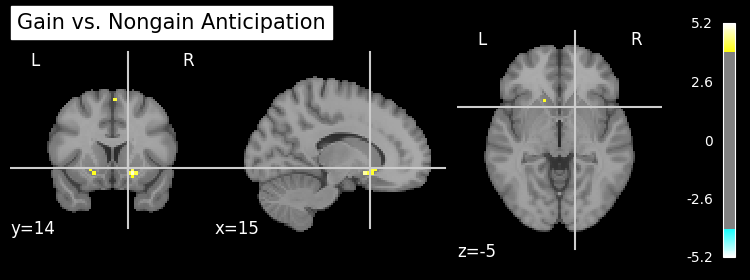

In [372]:
sub07_anticipation_gain_z_map = sub07_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_07, threshold = threshold_stats_img(sub07_anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    sub07_anticipation_gain_z_map,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



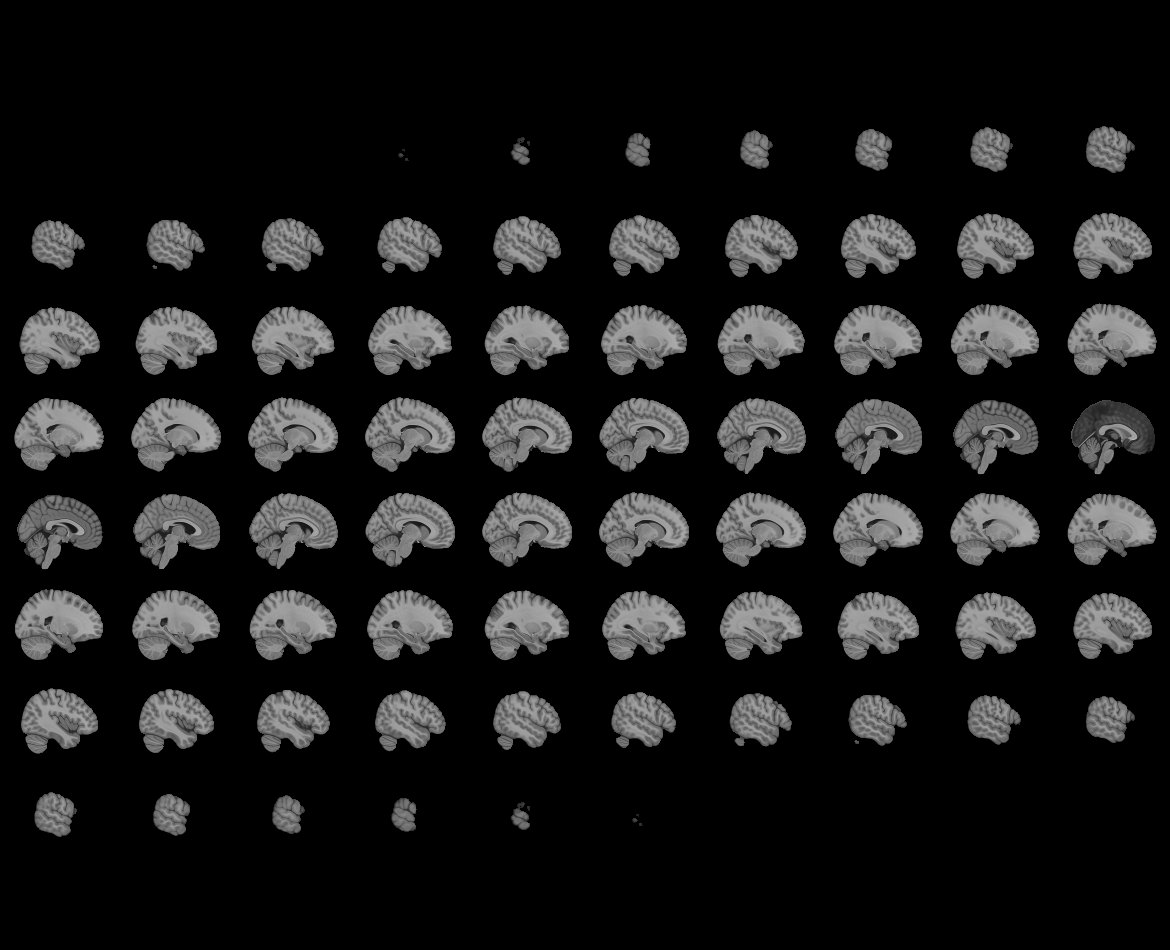
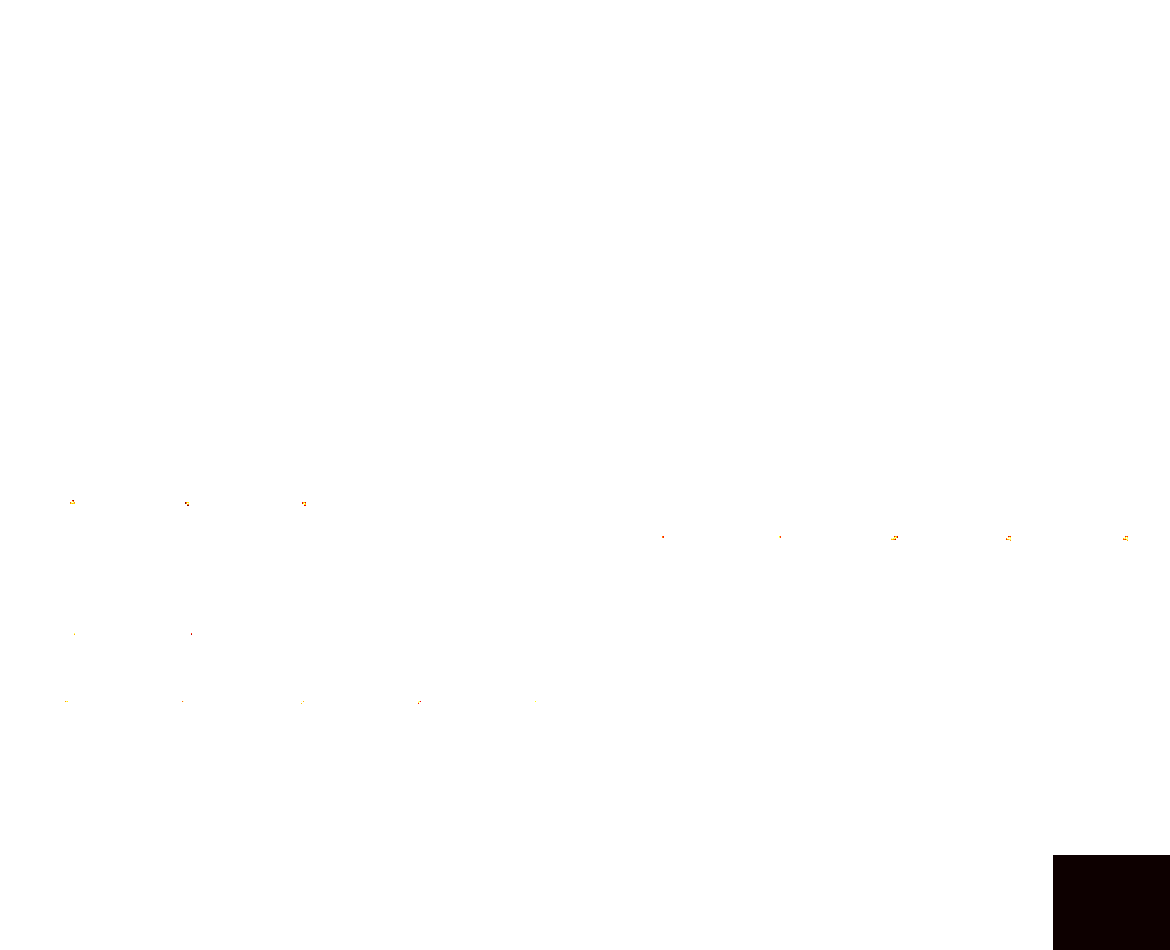

In [373]:
view = view_img(anticipation_gain_thresholded_map_07, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 008

In [375]:
# Load files for sub 008  
sub08_run1_func_file = "MID_preproc2/sub-08/func/sub-08_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub08_run1_mask_file = "MID_preproc2/sub-08/func/sub-08_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub08_file = 'MID_raw/sub-08/func/sub-08_task-MID_run-1_events.tsv'
sub08_run1_confounds_file = "MID_preproc2/sub-08/func/sub-08_task-MID_run-1_desc-confounds_timeseries.tsv"

# Calculate mean image to use as background image.
sub08_fmri_img = concat_imgs(sub08_run1_func_file)
sub08_func_file = nib.load(sub08_run1_func_file)
sub08_func_data = sub08_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub08_func_data.shape))

sub08_n_vols = sub08_func_data.shape[3]

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/4280499268.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub08_func_data = sub08_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [376]:
# Load participants file
sub08_run1_events_raw = pd.read_csv(sub08_file, sep='\t')
sub08_trials_num = sub08_run1_events_raw.shape[0]

print(f"run1_events shape: {sub08_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub08_trials_num}")

sub08_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0001        10      1        -$0      0.25        0.24145    1   
1  26.0008        10      2        -$1      0.25        0.23161    1   
2  40.0009         6      3        +$0      0.25        0.21111    1   
3  50.0011         8      4        +$5      0.25        0.23585    1   
4  62.0011        10      5        +$0      0.25       -1.00000    0   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $5.00    4  
4      $5.00    6

In [377]:
# Create events dataframe for sub008 run 1.
sub08_run1_events = create_events_df(sub08_run1_events_raw, sub08_trials_num, TR)

sub08_run1_events.head()

trial_type     onset duration
0         nonloss_hit  13.00010        2
1            response  13.24155      0.5
2  outome_nonloss_hit  20.00010        2
3     medium_loss_hit  27.00080        2
4            response  27.23241      0.5

In [378]:
# Load confounds file for sub008 run 1. 
sub08_run1_confounds_df = pd.read_csv(sub08_run1_confounds_file, sep='\t')
sub08_run1_confounds_df = sub08_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'non_steady_state_outlier00', 'non_steady_state_outlier01', "white_matter", "csf", "csf_wm", "tcompcor"]]

# Change NaNs to 0s. 
sub08_run1_confounds_df = sub08_run1_confounds_df.fillna(0) 
sub08_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y     rot_x     rot_z  \
0 -0.000083 -0.000015  0.032209 -0.000122  0.000681 -0.000070   
1 -0.000049 -0.099997 -0.199401 -0.000461 -0.000017  0.000214   
2 -0.018643 -0.098573 -0.323925 -0.000400  0.000446  0.000174   
3 -0.017397 -0.100728 -0.379742 -0.000410  0.000439  0.000257   
4 -0.024858 -0.119019 -0.409286 -0.000649  0.000104  0.000626   

   non_steady_state_outlier00  non_steady_state_outlier01  white_matter  \
0                         1.0                         0.0   1999.566813   
1                         0.0                         1.0   1768.864311   
2                         0.0                         0.0   1756.745411   
3                         0.0                         0.0   1750.733615   
4                         0.0                         0.0   1748.024439   

           csf       csf_wm     tcompcor  
0  3065.006446  2000.472684  2383.432302  
1  1790.689850  1764.933435  1748.788282  
2  1671.098123  1752.348480  1677.471599  
3  1615.254075  1746.172028  1610.267829  
4  1598.589388  1743.517954  1543.532283

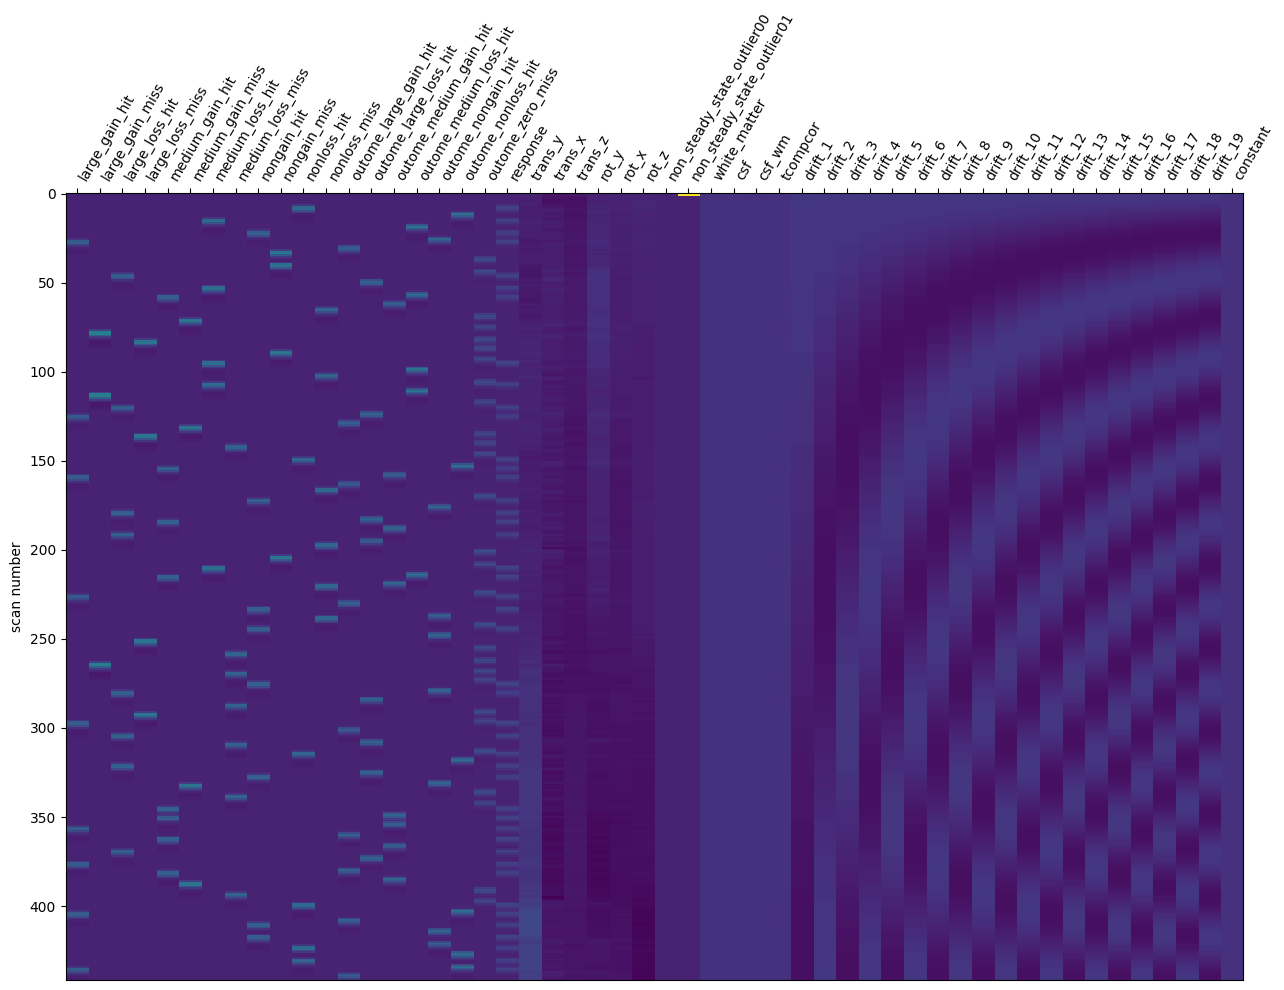

In [379]:
sub08_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model= "cosine",
    high_pass= 0.011,
    slice_time_ref=1, 
    mask_img=sub08_run1_mask_file,
    smoothing_fwhm = 4)

# Fit GLM model to events and confounds files. 
sub08_fmri_glm = sub07_fmri_glm.fit(sub08_run1_func_file, sub08_run1_events, sub08_run1_confounds_df)

plot_design_matrix(sub08_fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 2.902


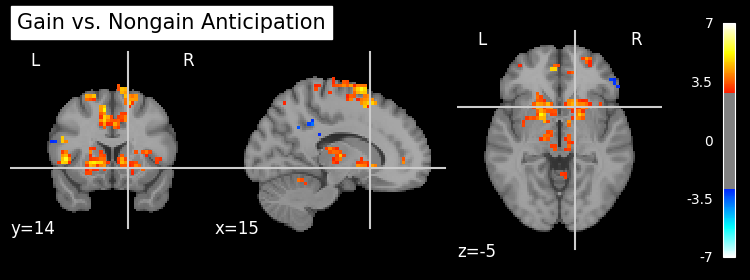

In [390]:
sub08_anticipation_gain_z_map = sub08_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_08, threshold = threshold_stats_img(sub08_anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    anticipation_gain_thresholded_map_08,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



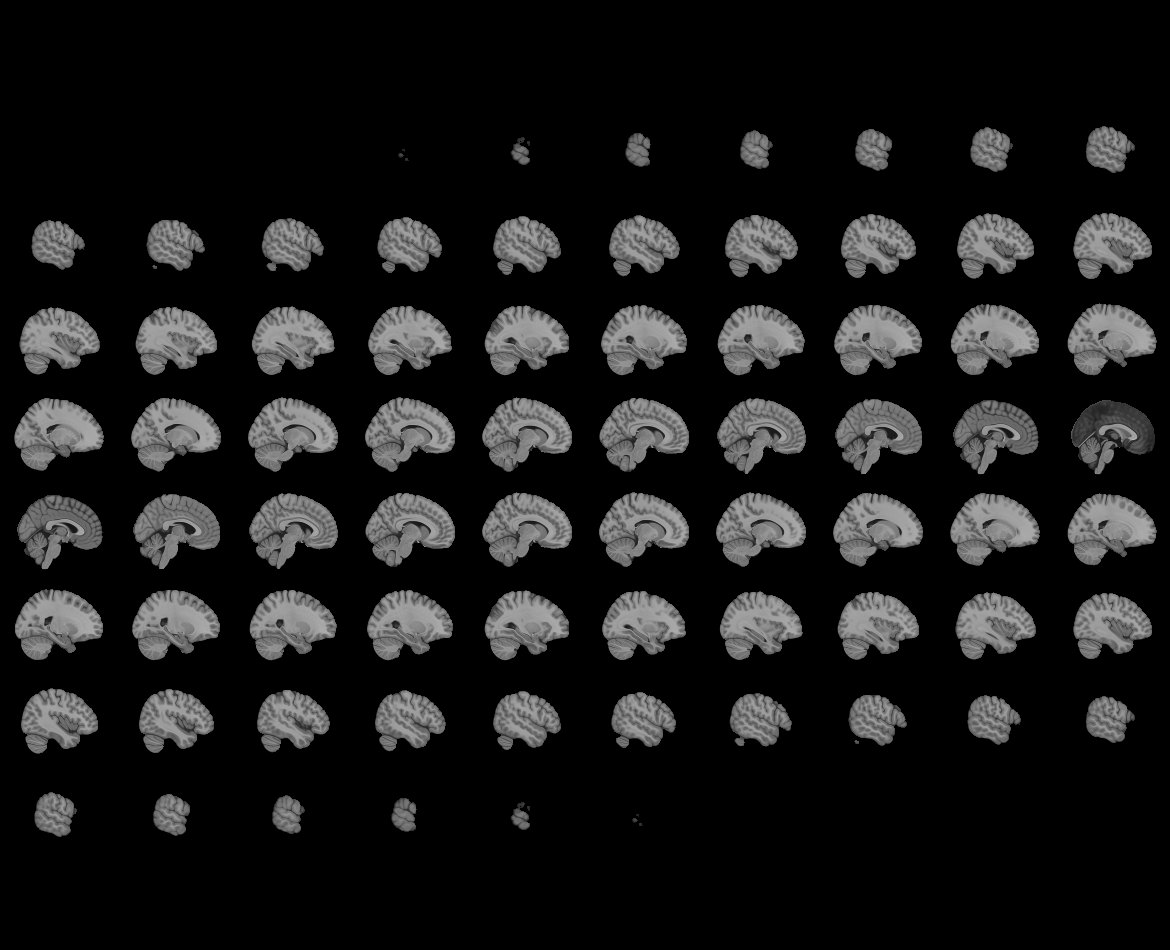
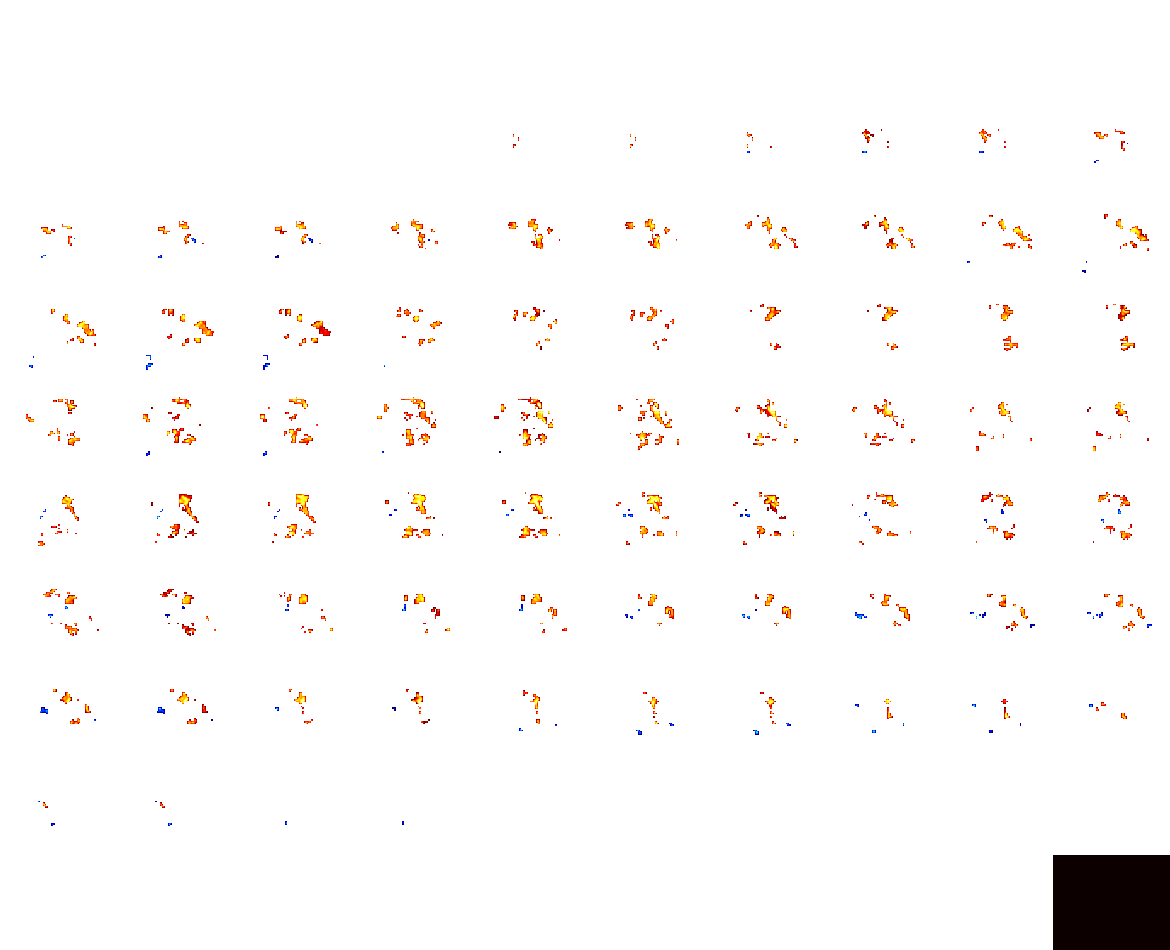

In [381]:
view = view_img(anticipation_gain_thresholded_map_08, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 009

In [382]:
# Load files for sub 009  
sub09_run1_func_file = "MID_preproc2/sub-09/func/sub-09_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub09_run1_mask_file = "MID_preproc2/sub-09/func/sub-09_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub09_file = 'MID_raw/sub-09/func/sub-09_task-MID_run-1_events.tsv'
sub09_run1_confounds_file = "MID_preproc2/sub-09/func/sub-09_task-MID_run-1_desc-confounds_timeseries.tsv"

# Calculate mean image to use as background image.
sub09_fmri_img = concat_imgs(sub09_run1_func_file)
sub09_func_file = nib.load(sub09_run1_func_file)
sub09_func_data = sub09_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub09_func_data.shape))

sub09_n_vols = sub09_func_data.shape[3]

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/1905571590.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub09_func_data = sub09_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [383]:
# Load participants file
sub09_run1_events_raw = pd.read_csv(sub09_file, sep='\t')
sub09_trials_num = sub09_run1_events_raw.shape[0]

print(f"run1_events shape: {sub09_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub09_trials_num}")

sub09_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0001        10      1        -$0      0.25       -1.00000    0   
1  26.0010        10      2        -$1      0.25        0.23906    1   
2  40.0011         6      3        +$0      0.25        0.23532    1   
3  50.0009         8      4        +$5      0.25        0.21137    1   
4  62.0008        10      5        +$0      0.25        0.23473    1   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $5.00    4  
4      $5.00    6

In [384]:
# Create events dataframe for sub009 run 1.
sub09_run1_events = create_events_df(sub09_run1_events_raw, sub09_trials_num, TR)

sub09_run1_events.head()

trial_type     onset duration
0            nonloss_miss  13.00010        2
1        outome_zero_miss  20.00010        2
2         medium_loss_hit  27.00100        2
3                response  27.24006      0.5
4  outome_medium_loss_hit  34.00100        2

In [385]:
# Load confounds file for sub009 run 1. 
sub09_run1_confounds_df = pd.read_csv(sub09_run1_confounds_file, sep='\t')
sub09_run1_confounds_df = sub09_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'non_steady_state_outlier00', 'non_steady_state_outlier01', "white_matter", "csf", "csf_wm", "tcompcor"]]

# Change NaNs to 0s. 
sub09_run1_confounds_df = sub09_run1_confounds_df.fillna(0) 
sub09_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y     rot_x     rot_z  \
0  0.019540 -0.032911  0.107922 -0.000644 -0.000408  0.000254   
1 -0.000164 -0.042583 -0.391535  0.000898  0.000549 -0.000467   
2 -0.018971  0.016162 -0.594661  0.001055  0.000610 -0.000702   
3 -0.000718 -0.007283 -0.688925  0.001048  0.000379 -0.000792   
4 -0.013053 -0.007182 -0.698889  0.001148  0.000171 -0.000637   

   non_steady_state_outlier00  non_steady_state_outlier01  white_matter  \
0                         1.0                         0.0   2040.615436   
1                         0.0                         1.0   1793.608049   
2                         0.0                         0.0   1780.823088   
3                         0.0                         0.0   1775.693226   
4                         0.0                         0.0   1771.458514   

           csf       csf_wm     tcompcor  
0  3789.447622  2060.510172  2793.367235  
1  1972.047232  1785.141851  1901.451007  
2  1878.800933  1774.265846  1758.068823  
3  1830.236855  1768.314841  1760.218603  
4  1816.993163  1764.237723  1712.361673

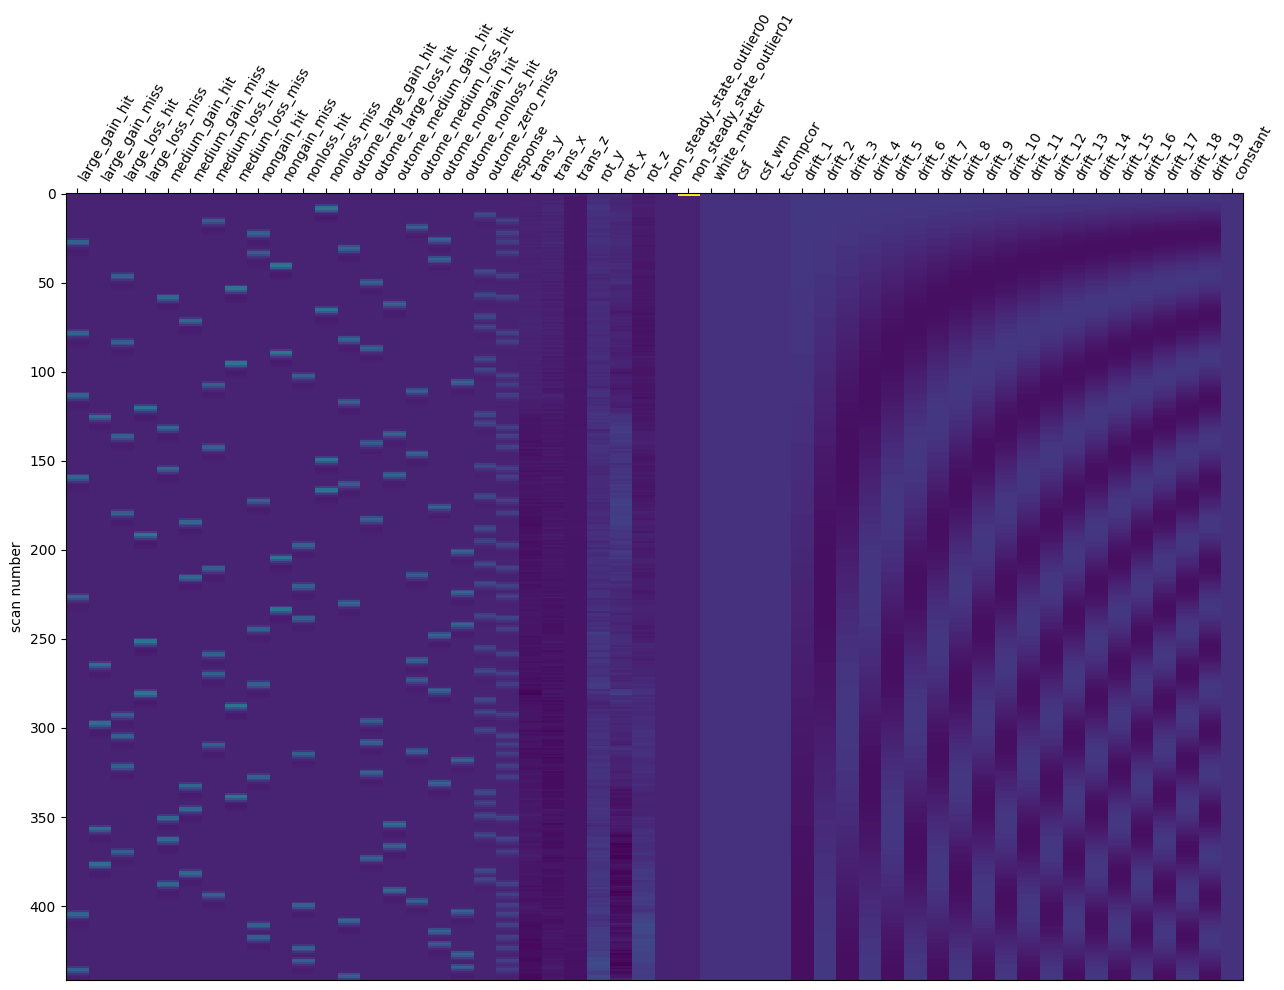

In [386]:
sub09_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model= "cosine",
    high_pass= 0.011,
    slice_time_ref=1, 
    mask_img=sub09_run1_mask_file,
    smoothing_fwhm = 4)

# Fit GLM model to events and confounds files. 
sub09_fmri_glm = sub09_fmri_glm.fit(sub09_run1_func_file, sub09_run1_events, sub09_run1_confounds_df)

plot_design_matrix(sub09_fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 2.806


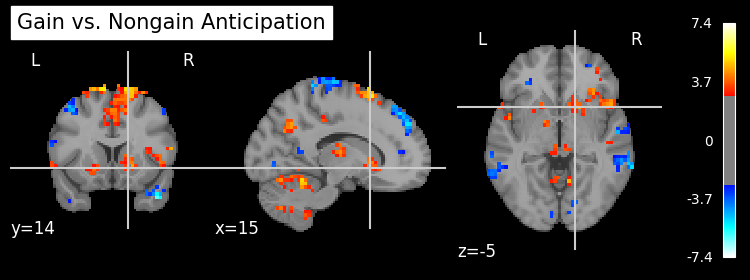

In [389]:
sub09_anticipation_gain_z_map = sub09_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_09, threshold = threshold_stats_img(sub09_anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    anticipation_gain_thresholded_map_09,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



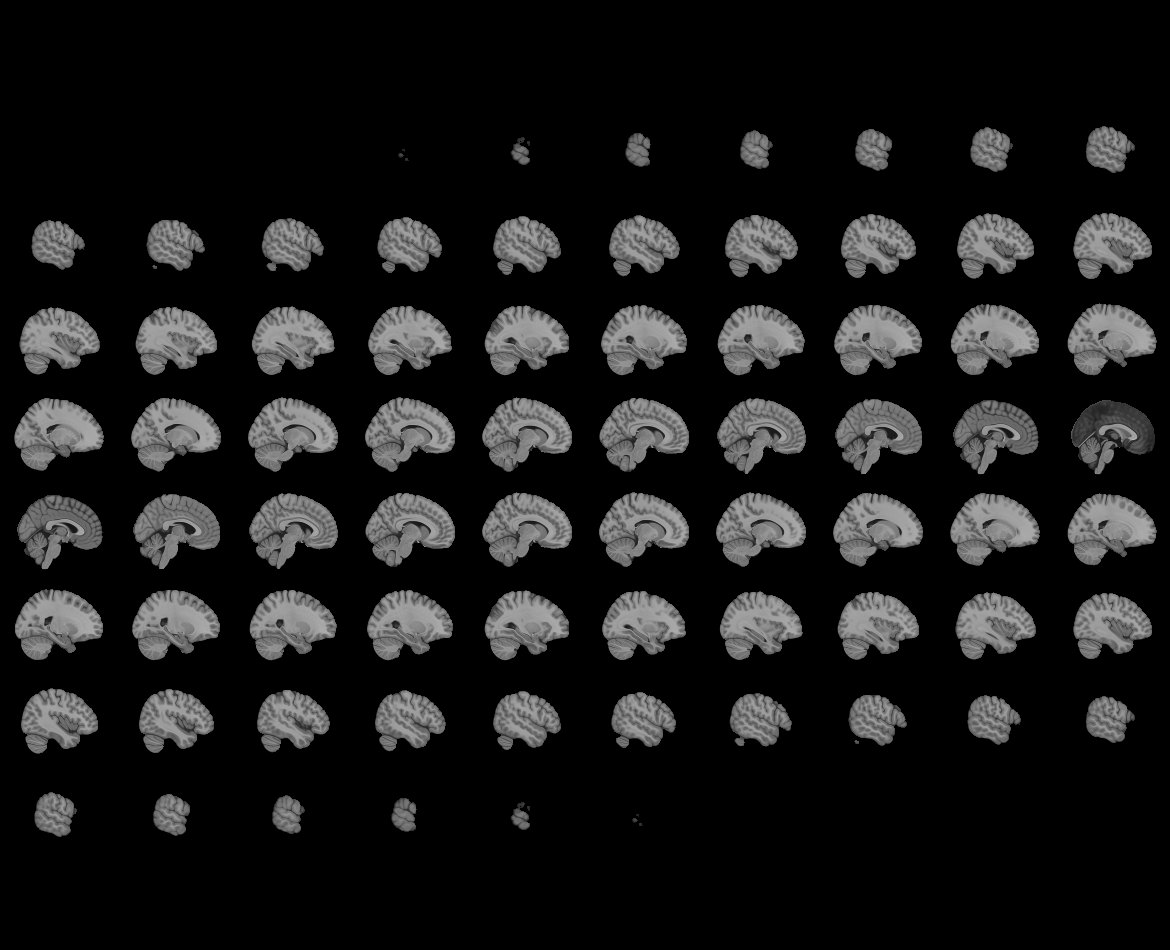
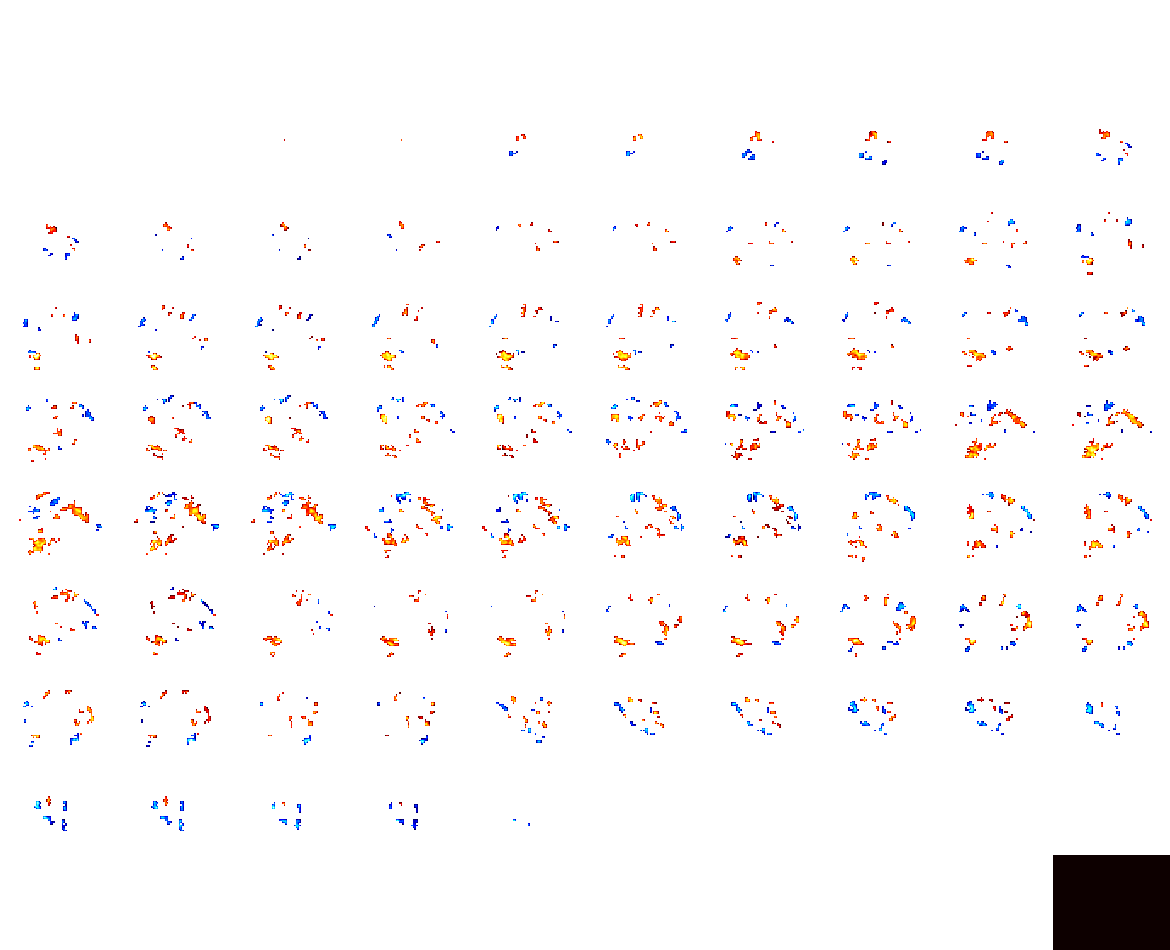

In [388]:
view = view_img(anticipation_gain_thresholded_map_09, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 0010

In [396]:
# Load files for sub 0010  
sub010_run1_func_file = "MID_preproc2/sub-10/func/sub-10_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub010_run1_mask_file = "MID_preproc2/sub-10/func/sub-10_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub010_file = 'MID_raw/sub-10/func/sub-10_task-MID_run-1_events.tsv'
sub010_run1_confounds_file = "MID_preproc2/sub-10/func/sub-10_task-MID_run-1_desc-confounds_timeseries.tsv"

# Calculate mean image to use as background image.
sub010_fmri_img = concat_imgs(sub010_run1_func_file)
sub010_func_file = nib.load(sub010_run1_func_file)
sub010_func_data = sub010_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub010_func_data.shape))

sub010_n_vols = sub010_func_data.shape[3]

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/1646582086.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub010_func_data = sub010_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [394]:
# Load participants file
sub010_run1_events_raw = pd.read_csv(sub010_file, sep='\t')
sub010_trials_num = sub010_run1_events_raw.shape[0]

print(f"run1_events shape: {sub010_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub010_trials_num}")

sub010_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0007        10      1         $0      0.25       -1.00000    0   
1  26.0028        10      2       ($1)      0.25        0.22935    1   
2  40.0021         6      3         $0      0.25        0.23600    1   
3  50.0014         8      4         $5      0.25        0.23895    1   
4  62.0009        10      5         $0      0.25        0.22636    1   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $5.00    4  
4      $5.00    6

In [397]:
# Create events dataframe for sub0010 run 1.
sub010_run1_events = create_events_df(sub010_run1_events_raw, sub010_trials_num, TR)

sub010_run1_events.head()
#Weird formatting of events file

There appears to be an error with trial 0


UnboundLocalError: local variable 'current_trialtype' referenced before assignment

In [ ]:
# Load confounds file for sub0010 run 1. 
sub010_run1_confounds_df = pd.read_csv(sub010_run1_confounds_file, sep='\t')
sub010_run1_confounds_df = sub010_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'non_steady_state_outlier00', 'non_steady_state_outlier01', "white_matter", "csf", "csf_wm", "tcompcor"]]

# Change NaNs to 0s. 
sub010_run1_confounds_df = sub010_run1_confounds_df.fillna(0) 
sub010_run1_confounds_df.head()

In [ ]:
sub010_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model= "cosine",
    high_pass= 0.011,
    slice_time_ref=1, 
    mask_img=sub010_run1_mask_file,
    smoothing_fwhm = 4)

# Fit GLM model to events and confounds files. 
sub010_fmri_glm = sub010_fmri_glm.fit(sub010_run1_func_file, sub010_run1_events, sub010_run1_confounds_df)

plot_design_matrix(sub010_fmri_glm.design_matrices_[0])

plt.show()

In [ ]:
sub010_anticipation_gain_z_map = sub010_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_010, threshold = threshold_stats_img(sub010_anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    sub010_anticipation_gain_z_map,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

In [ ]:
view = view_img(anticipation_gain_thresholded_map_010, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 0011

In [399]:
# Load files for sub 0011  
sub011_run1_func_file = "MID_preproc2/sub-11/func/sub-11_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub011_run1_mask_file = "MID_preproc2/sub-11/func/sub-11_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub011_file = 'MID_raw/sub-11/func/sub-11_task-MID_run-1_events.tsv'
sub011_run1_confounds_file = "MID_preproc2/sub-11/func/sub-11_task-MID_run-1_desc-confounds_timeseries.tsv"

# Calculate mean image to use as background image.
sub011_fmri_img = concat_imgs(sub011_run1_func_file)
sub011_func_file = nib.load(sub011_run1_func_file)
sub011_func_data = sub011_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub011_func_data.shape))

sub011_n_vols = sub011_func_data.shape[3]

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/965871260.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub011_func_data = sub011_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [400]:
# Load participants file
sub011_run1_events_raw = pd.read_csv(sub011_file, sep='\t')
sub011_trials_num = sub011_run1_events_raw.shape[0]

print(f"run1_events shape: {sub011_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub011_trials_num}")

sub011_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0007        10      1        -$0      0.25       -1.00000    0   
1  26.0025        10      2        -$1      0.25        0.23778    1   
2  40.0022         6      3        +$0      0.25        0.22277    1   
3  50.0014         8      4        +$5      0.25        0.22344    1   
4  62.0010        10      5        +$0      0.25       -1.00000    0   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $5.00    4  
4      $5.00    6

In [401]:
# Create events dataframe for sub0011 run 1.
sub011_run1_events = create_events_df(sub011_run1_events_raw, sub011_trials_num, TR)

sub011_run1_events.head()

trial_type     onset duration
0            nonloss_miss  13.00070        2
1        outome_zero_miss  20.00070        2
2         medium_loss_hit  27.00250        2
3                response  27.24028      0.5
4  outome_medium_loss_hit  34.00250        2

In [402]:
# Load confounds file for sub0011 run 1. 
sub011_run1_confounds_df = pd.read_csv(sub011_run1_confounds_file, sep='\t')
sub011_run1_confounds_df = sub011_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'non_steady_state_outlier00', 'non_steady_state_outlier01', "white_matter", "csf", "csf_wm", "tcompcor"]]

# Change NaNs to 0s. 
sub011_run1_confounds_df = sub011_run1_confounds_df.fillna(0) 
sub011_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y     rot_x     rot_z  \
0  0.000365  0.000225  0.018373  0.000482 -0.000588 -0.000399   
1 -0.012216 -0.082569 -0.212726 -0.001472 -0.000365 -0.000617   
2 -0.009671 -0.095617 -0.285842 -0.001076 -0.000345 -0.000522   
3  0.000961 -0.076711 -0.277481 -0.001606 -0.000971 -0.000470   
4 -0.003104 -0.114907 -0.277504 -0.002827 -0.001321 -0.000432   

   non_steady_state_outlier00  non_steady_state_outlier01  white_matter  \
0                         1.0                         0.0   2138.945013   
1                         0.0                         1.0   1850.375003   
2                         0.0                         0.0   1847.555039   
3                         0.0                         0.0   1849.197642   
4                         0.0                         0.0   1850.087817   

           csf       csf_wm     tcompcor  
0  2837.222300  2138.666136  2667.185796  
1  1690.237918  1849.909212  1889.080542  
2  1671.073195  1847.119162  1867.218610  
3  1656.021453  1848.749158  1874.995867  
4  1650.128277  1849.638307  1861.169779

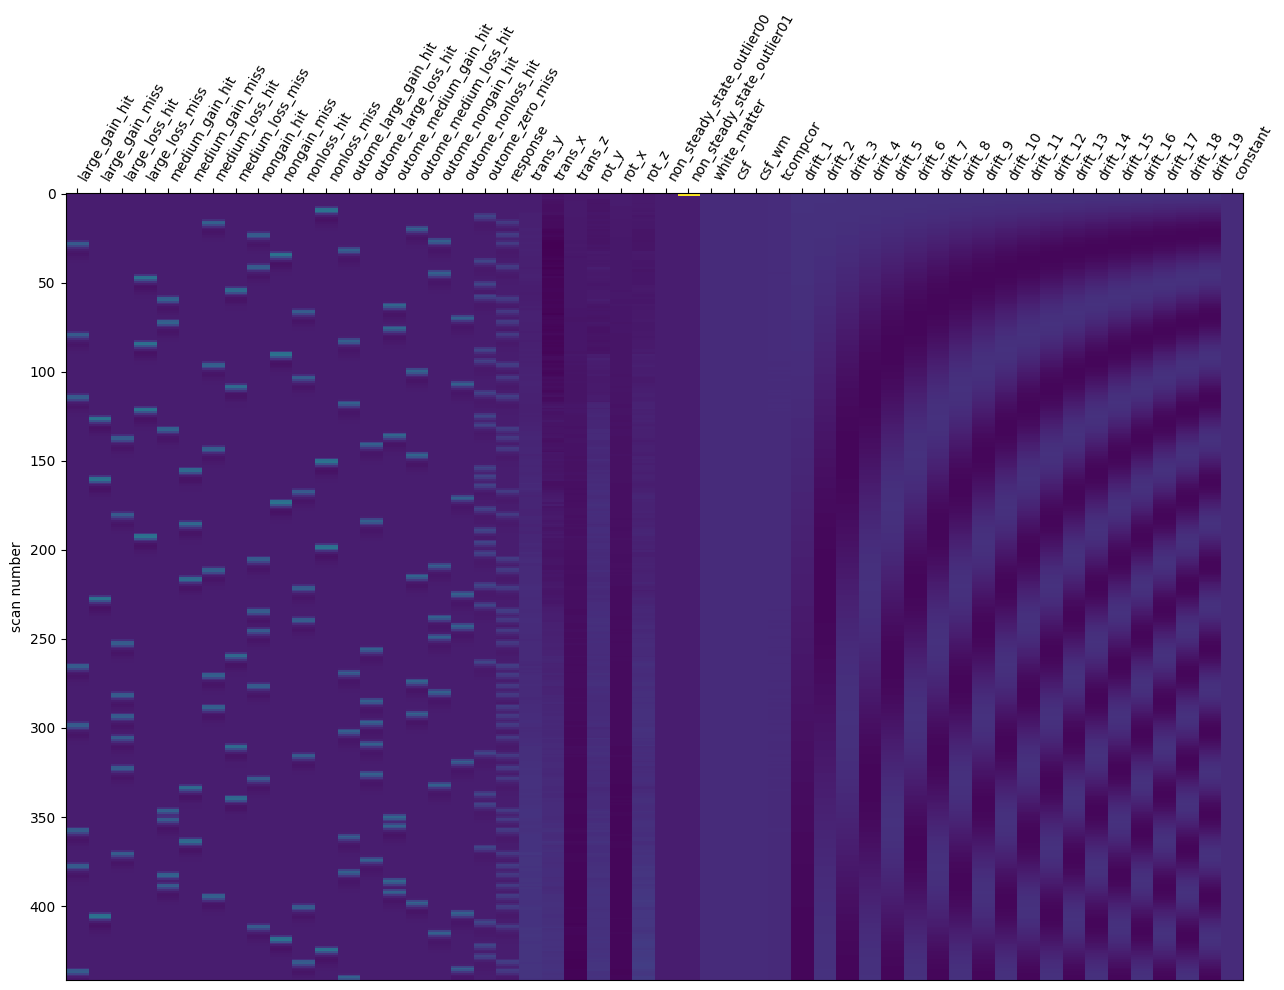

In [410]:
sub011_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model= "cosine",
    high_pass= 0.011,
    slice_time_ref=0, 
    mask_img=sub011_run1_mask_file,
    smoothing_fwhm = 4)

# Fit GLM model to events and confounds files. 
sub011_fmri_glm = sub011_fmri_glm.fit(sub011_run1_func_file, sub011_run1_events, sub011_run1_confounds_df)

plot_design_matrix(sub011_fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 1.960


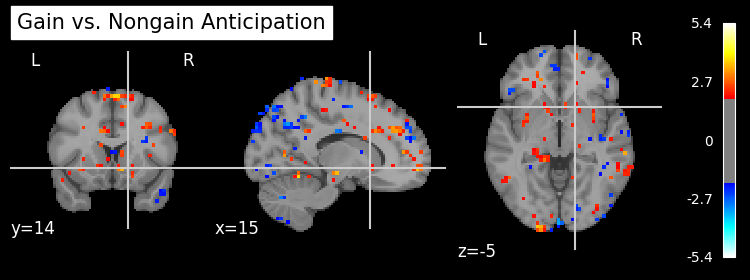

In [411]:
sub011_anticipation_gain_z_map = sub011_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_011, threshold = threshold_stats_img(sub011_anticipation_gain_z_map, alpha=0.05, height_control="fpr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    sub011_anticipation_gain_z_map,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

In [ ]:
view = view_img(anticipation_gain_thresholded_map_011, threshold=threshold, cut_coords=[15, 14, -5])

view

# Run GLM on Subject 0012

In [412]:
# Load files for sub 0012  
sub012_run1_func_file = "MID_preproc2/sub-12/func/sub-12_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
sub012_run1_mask_file = "MID_preproc2/sub-12/func/sub-12_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
sub012_file = 'MID_raw/sub-12/func/sub-12_task-MID_run-1_events.tsv'
sub012_run1_confounds_file = "MID_preproc2/sub-12/func/sub-12_task-MID_run-1_desc-confounds_timeseries.tsv"

# Calculate mean image to use as background image.
sub012_fmri_img = concat_imgs(sub012_run1_func_file)
sub012_func_file = nib.load(sub012_run1_func_file)
sub012_func_data = sub012_func_file.get_data()

print("File of fist run 1 has shape: %s" % str(sub012_func_data.shape))

sub012_n_vols = sub012_func_data.shape[3]

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_11541/402669036.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  sub012_func_data = sub012_func_file.get_data()


File of fist run 1 has shape: (58, 69, 58, 442)


In [413]:
# Load participants file
sub012_run1_events_raw = pd.read_csv(sub012_file, sep='\t')
sub012_trials_num = sub012_run1_events_raw.shape[0]

print(f"run1_events shape: {sub012_run1_events_raw.shape}")
print(f"Run 1 number of trials: {sub012_trials_num}")

sub012_run1_events_raw.head()

run1_events shape: (72, 9)
Run 1 number of trials: 72


onset  duration  trial trial_type  target_s  response_time  hit  \
0  12.0001        10      1        -$0      0.25        0.20547    1   
1  26.0009        10      2        -$1      0.25        0.21386    1   
2  40.0008         6      3        +$0      0.25       -1.00000    0   
3  50.0006         8      4        +$5      0.25        0.20726    1   
4  62.0007        10      5        +$0      0.25        0.20834    1   

  total_gain  iti  
0      $0.00    6  
1      $0.00    6  
2      $0.00    2  
3      $5.00    4  
4      $5.00    6

In [428]:
# Create events dataframe for sub0012 run 1.
sub012_run1_events = create_events_df(sub012_run1_events_raw, sub012_trials_num, 0)

sub012_run1_events.head()

trial_type     onset duration
0         nonloss_hit  12.00010        2
1            response  12.20557      0.5
2  outome_nonloss_hit  19.00010        2
3     medium_loss_hit  26.00090        2
4            response  26.21476      0.5

In [429]:
# Load confounds file for sub0012 run 1. 
sub012_run1_confounds_df = pd.read_csv(sub012_run1_confounds_file, sep='\t')
sub012_run1_confounds_df = sub012_run1_confounds_df[['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', 'non_steady_state_outlier00', 'non_steady_state_outlier01', "white_matter", "csf", "csf_wm", "tcompcor"]]

# Change NaNs to 0s. 
sub012_run1_confounds_df = sub012_run1_confounds_df.fillna(0) 
sub012_run1_confounds_df.head()

trans_y   trans_x   trans_z     rot_y     rot_x     rot_z  \
0 -0.000104  0.000032  0.032094  0.000397  0.000081  0.000573   
1  0.025686 -0.030347 -0.209307  0.000415  0.000391 -0.000111   
2  0.015780 -0.079498 -0.399803 -0.000820  0.000564 -0.000227   
3  0.022146 -0.077216 -0.435553 -0.000865  0.000544 -0.000111   
4  0.035017 -0.047773 -0.403741 -0.000660  0.000544 -0.000111   

   non_steady_state_outlier00  non_steady_state_outlier01  white_matter  \
0                         1.0                         0.0   2010.172644   
1                         0.0                         1.0   1753.012253   
2                         0.0                         0.0   1742.050313   
3                         0.0                         0.0   1739.953164   
4                         0.0                         0.0   1739.519342   

           csf       csf_wm     tcompcor  
0  3025.474573  2009.525363  2340.882099  
1  1669.801042  1751.765282  1716.987541  
2  1555.501091  1740.526562  1589.820012  
3  1540.383004  1738.639414  1591.622405  
4  1548.423526  1738.177610  1622.919151

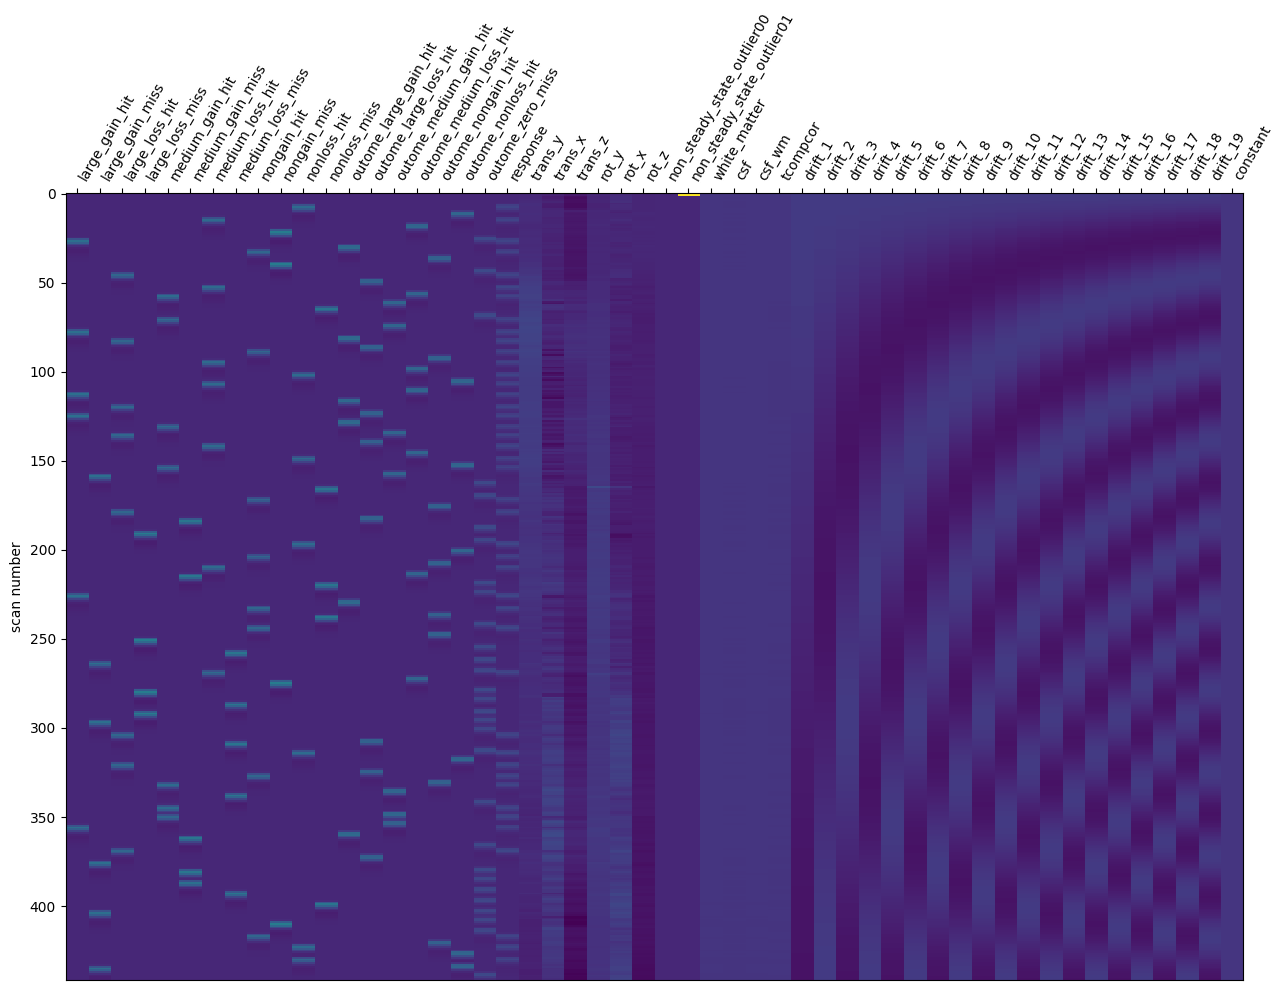

In [430]:
sub012_fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model= "cosine",
    high_pass= 0.011,
    slice_time_ref=1, 
    mask_img=sub012_run1_mask_file,
    smoothing_fwhm = 4)

# Fit GLM model to events and confounds files. 
sub012_fmri_glm = sub012_fmri_glm.fit(sub012_run1_func_file, sub012_run1_events, sub012_run1_confounds_df)

plot_design_matrix(sub012_fmri_glm.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 3.891


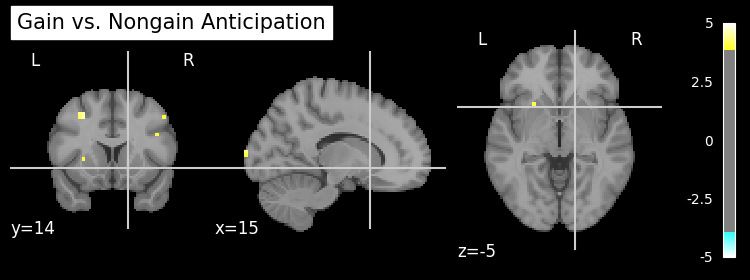

In [432]:
sub012_anticipation_gain_z_map = sub012_fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

anticipation_gain_thresholded_map_012, threshold = threshold_stats_img(sub012_anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    sub012_anticipation_gain_z_map,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Gain vs. Nongain Anticipation"
)
plt.show()

In [ ]:
view = view_img(anticipation_gain_thresholded_map_012, threshold=threshold, cut_coords=[15, 14, -5])

view

In [40]:
"""gain_contrast = "+1*outome_large_gain_hit+1*outome_medium_gain_hit-2*outome_nongain_hit"

z_map = fmri_glm.compute_contrast(contrast_def=gain_contrast, output_type="z_score")

_, threshold = threshold_stats_img(z_map, alpha=0.01, height_control="fpr")
print(f"Uncorrected p<0.001 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    threshold=threshold,
    black_bg=True
)
plt.show()

_, threshold = threshold_stats_img(z_map, alpha=0.01, height_control="fpr")
print(f"Uncorrected p<0.001 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    threshold=threshold,
    black_bg=True
)
plt.show()

"""

'gain_contrast = "+1*outome_large_gain_hit+1*outome_medium_gain_hit-2*outome_nongain_hit"\n\nz_map = fmri_glm.compute_contrast(contrast_def=gain_contrast, output_type="z_score")\n\n_, threshold = threshold_stats_img(z_map, alpha=0.01, height_control="fpr")\nprint(f"Uncorrected p<0.001 threshold: {threshold:.3f}")\nplot_stat_map(\n    z_map,\n    threshold=threshold,\n    black_bg=True\n)\nplt.show()\n\n_, threshold = threshold_stats_img(z_map, alpha=0.01, height_control="fpr")\nprint(f"Uncorrected p<0.001 threshold: {threshold:.3f}")\nplot_stat_map(\n    z_map,\n    threshold=threshold,\n    black_bg=True\n)\nplt.show()\n\n'